In [1]:
import glob
from itertools import chain
import json
import os
import re

import numpy as np
import pandas as pd

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fe = fm.FontEntry(
    fname=r'./res/NanumGothic.ttf', name='NanumGothic')                       
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) 

plt.rcParams["figure.figsize"] = (20, 10)
register_matplotlib_converters()

In [2]:
path = './res/'

### 1. 장르 & song_meta 관련

>  song_meta 수정

- song_meta 내 발매년도 오류 날짜 수정

In [157]:
# song_meta 파일 읽기
song_meta = pd.read_json(path + 'song_meta.json', typ = 'frame')

# genre_gn_all 파일 읽기
genre_gn_all = pd.read_json(path + 'genre_gn_all.json', typ = 'series')
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})

In [158]:
song_meta.info() # 707989, 9

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  int64 
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_basket        707989 non-null  object
 5   song_name               707989 non-null  object
 6   song_gn_gnr_basket      707989 non-null  object
 7   artist_name_basket      707989 non-null  object
 8   id                      707989 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 48.6+ MB


In [159]:
# 'issue_date' 값을 변경할 행의 인덱스 추출
indices_to_update = [141185, 448286]  # 변경하려는 행의 인덱스 목록

# 'issue_date' 값을 변경할 값으로 설정
new_value = 20200113

# 특정 행의 'issue_date' 값을 변경
for idx in indices_to_update:
    song_meta.at[idx, 'issue_date'] = new_value

In [160]:
# 날짜가 제대로 변경되었는지
song_meta[song_meta['issue_date'] >= 20200500]['issue_date']

Series([], Name: issue_date, dtype: int64)

- 장르 정보가 없는 노래 제거

In [161]:
# GN9000 장르 이름 없음
genre_gn_all = genre_gn_all.sort_values('gnr_code')
genre_gn_all[genre_gn_all['gnr_code'] == 'GN9000']

,gnr_code,gnr_name


In [162]:
# song_meta에 GN9000 장르를 가진 행 찾기

target_genre = 'GN9000'
filtered_rows = song_meta[song_meta['song_gn_gnr_basket'].apply(lambda x: 'GN9000' in x)]

filtered_rows.iloc[40:50, :] # shape(1834, 9)

# 사랑하는 아기를 위한 태교 클래식, 크리스마스 캐롤 노래 차분한 자장가 재즈 피아노 연주곡, 흥부와 놀부 (동화뮤지컬) 등 <- 앨범명	
# 태교, 찬양곡, 뮤지컬 음악 등 분류하기 애매한 노래들

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
16584,[],20080811,Because Of You,393251,[25330],주님과 함께면,[GN9000],[박명선 수산나],16584
16792,[],20150728,Top Music 최신 인기가요 베스트 MR 30집,2331658,[725576],Loser (MR),[GN9000],[Top Music],16792
17401,[],20180629,Party Tyme Karaoke - Latin Urban Hits 2,10183698,[1096578],Quiero Bailar (Made Popular By Ivy Queen) [Kar...,[GN9000],[Party Tyme Karaoke],17401
17589,[],20141202,페네로페와 보내는 즐거운 크리스마스,2293119,[733931],Silent Night,[GN9000],[Minami Risa],17589
17614,[],20190104,해피스마일 최신 유치원 인기 동요 베스트,10239048,[2727],다시 한 번 더 (TV 만화 `또봇` 오프닝),[GN9000],[Various Artists],17614
17834,[],20191114,Hate Her Friends (feat. Juice WRLD),10351740,[2754718],Hate Her Friends (Original Mix) (feat. Juice W...,[GN9000],[Jeremiah],17834
18197,[],20161216,크리스마스 노래 캐롤 감성 피아노 연주곡 베스트,10023709,[601338],크리스마스 폴카,[GN9000],[크리스마스],18197
19182,[],20190116,흥부와 놀부 (동화뮤지컬),10242509,[720223],어기영차 박을 열자 (노래),[GN9000],[주니토니],19182
19220,[],20170111,MR반주 뮤직엔 2017 Vol.01,10030511,[658031],Beautiful (Melody 포함 MR),[GN9000],[Musicen],19220
19485,[],20151201,세상을 따뜻하게 안아주는 사랑스러운 태교 피아노,2653741,[714000],바다 노을,[GN9000],[피아노 라떼],19485


In [163]:
filtered_rows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1834 entries, 262 to 707869
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   song_gn_dtl_gnr_basket  1834 non-null   object
 1   issue_date              1834 non-null   int64 
 2   album_name              1834 non-null   object
 3   album_id                1834 non-null   int64 
 4   artist_id_basket        1834 non-null   object
 5   song_name               1834 non-null   object
 6   song_gn_gnr_basket      1834 non-null   object
 7   artist_name_basket      1834 non-null   object
 8   id                      1834 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 143.3+ KB


In [164]:
song_meta = song_meta.drop(filtered_rows.index)
song_meta.info() # 706155, 9

<class 'pandas.core.frame.DataFrame'>
Int64Index: 706155 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  706155 non-null  object
 1   issue_date              706155 non-null  int64 
 2   album_name              706151 non-null  object
 3   album_id                706155 non-null  int64 
 4   artist_id_basket        706155 non-null  object
 5   song_name               706155 non-null  object
 6   song_gn_gnr_basket      706155 non-null  object
 7   artist_name_basket      706155 non-null  object
 8   id                      706155 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 53.9+ MB


In [166]:
# 새로운 song_meta 저장
song_meta.to_json('./origin_data_modify/song_meta_mod1.json')

In [209]:
song_meta = pd.read_json('./origin_data_modify/song_meta_mod1.json', typ = 'frame')
song_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 706155 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  706155 non-null  object
 1   issue_date              706155 non-null  int64 
 2   album_name              706151 non-null  object
 3   album_id                706155 non-null  int64 
 4   artist_id_basket        706155 non-null  object
 5   song_name               706155 non-null  object
 6   song_gn_gnr_basket      706155 non-null  object
 7   artist_name_basket      706155 non-null  object
 8   id                      706155 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 53.9+ MB


- 각 곡 별 매핑된 장르 개수
    - 대부분의 곡들은 1개의 대분류 장르와 매핑
    - 전체 곡의 약 13%는 2개 이상의 대분류 장르를 가짐

In [210]:
# 대분류 장르코드들만 뽑기
gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:]=='00']

# 장르코드 뒷자리 두 자리가 00이 아닌 코드를 필터링
dtl_gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] != '00']
dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)
dtl_gnr_code

C:\Users\cg063\AppData\Local\Temp\ipykernel_11320\2904836111.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)


,dtl_gnr_code,dtl_gnr_name
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00
5,GN0105,'10-
...,...,...
247,GN2805,숙면유도
248,GN2806,반려동물
250,GN2901,세부장르전체
251,GN2902,국내뮤지컬


In [212]:
# gnr_code_tree 파일 만들기

# 앞자리 네 자리 공통코드 추출
gnr_code = gnr_code.assign(join_code = gnr_code['gnr_code'].str[0:4])
dtl_gnr_code = dtl_gnr_code.assign(join_code = dtl_gnr_code['dtl_gnr_code'].str[0:4])

# Merge
gnr_code_tree = pd.merge(gnr_code, dtl_gnr_code, how = 'left', on = 'join_code')

gnr_code_tree[['gnr_code', 'gnr_name', 'dtl_gnr_code', 'dtl_gnr_name']]
gnr_code_tree

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
0,GN0100,발라드,GN01,GN0101,세부장르전체
1,GN0100,발라드,GN01,GN0102,'80
2,GN0100,발라드,GN01,GN0103,'90
3,GN0100,발라드,GN01,GN0104,'00
4,GN0100,발라드,GN01,GN0105,'10-
...,...,...,...,...,...
220,GN2800,뮤직테라피,GN28,GN2806,반려동물
221,GN2900,뮤지컬,GN29,GN2901,세부장르전체
222,GN2900,뮤지컬,GN29,GN2902,국내뮤지컬
223,GN2900,뮤지컬,GN29,GN2903,국외뮤지컬


In [213]:
# 장르코드 파일 저장
gnr_code_tree.to_csv('./origin_data_modify/gnr_code_tree.csv', index=False)

In [214]:
# 곡 아이디(id)와 대분류 장르코드 리스트(song_gn_gnr_basket) 추출
song_gnr_map = song_meta.loc[:, ['id', 'song_gn_gnr_basket']]

# unnest song_gn_gnr_basket
song_gnr_map_unnest = np.dstack(
    (
        np.repeat(song_gnr_map.id.values, list(map(len, song_gnr_map.song_gn_gnr_basket))), 
        np.concatenate(song_gnr_map.song_gn_gnr_basket.values)
    )
)

# unnested 데이터프레임 생성 : song_gnr_map
song_gnr_map = pd.DataFrame(data = song_gnr_map_unnest[0], columns = song_gnr_map.columns)
song_gnr_map['id'] = song_gnr_map['id'].astype(str)
song_gnr_map.rename(columns = {'id' : 'song_id', 'song_gn_gnr_basket' : 'gnr_code'}, inplace = True)

# unnest 객체 제거
del song_gnr_map_unnest

song_gnr_map

,song_id,gnr_code
0,0,GN0900
1,1,GN1600
2,2,GN0900
3,3,GN1100
4,4,GN1800
...,...,...
801020,707984,GN2000
801021,707985,GN0900
801022,707986,GN0100
801023,707987,GN1800


In [215]:
# 1. 곡 별 장르 개수 count 테이블 생성 : song_gnr_count
song_gnr_count = song_gnr_map.groupby('song_id').gnr_code.nunique().reset_index(name = 'mapping_gnr_cnt')

# 2. 1번에서 생성한 테이블을 가지고 매핑된 장르 개수 별 곡 수 count 테이블 생성 : gnr_song_count
gnr_song_count = song_gnr_count.groupby('mapping_gnr_cnt').song_id.nunique().reset_index(name = '매핑된 곡 수')

# 3. 2번 테이블에 비율 값 추가
gnr_song_count.loc[:, '비율(%)'] = round(gnr_song_count['매핑된 곡 수']/sum(gnr_song_count['매핑된 곡 수'])*100, 2)
gnr_song_count = gnr_song_count.reset_index().rename(columns = {'mapping_gnr_cnt' : '장르 수'})
gnr_song_count[['장르 수', '매핑된 곡 수', '비율(%)']]

,장르 수,매핑된 곡 수,비율(%)
0,1,610972,86.65
1,2,92378,13.10
2,3,1694,0.24
3,4,48,0.01
4,5,1,0.00
5,6,3,0.00


(-1.099999829779462,
 1.0999999650440107,
 -1.0999999275082175,
 1.0999999965480103)

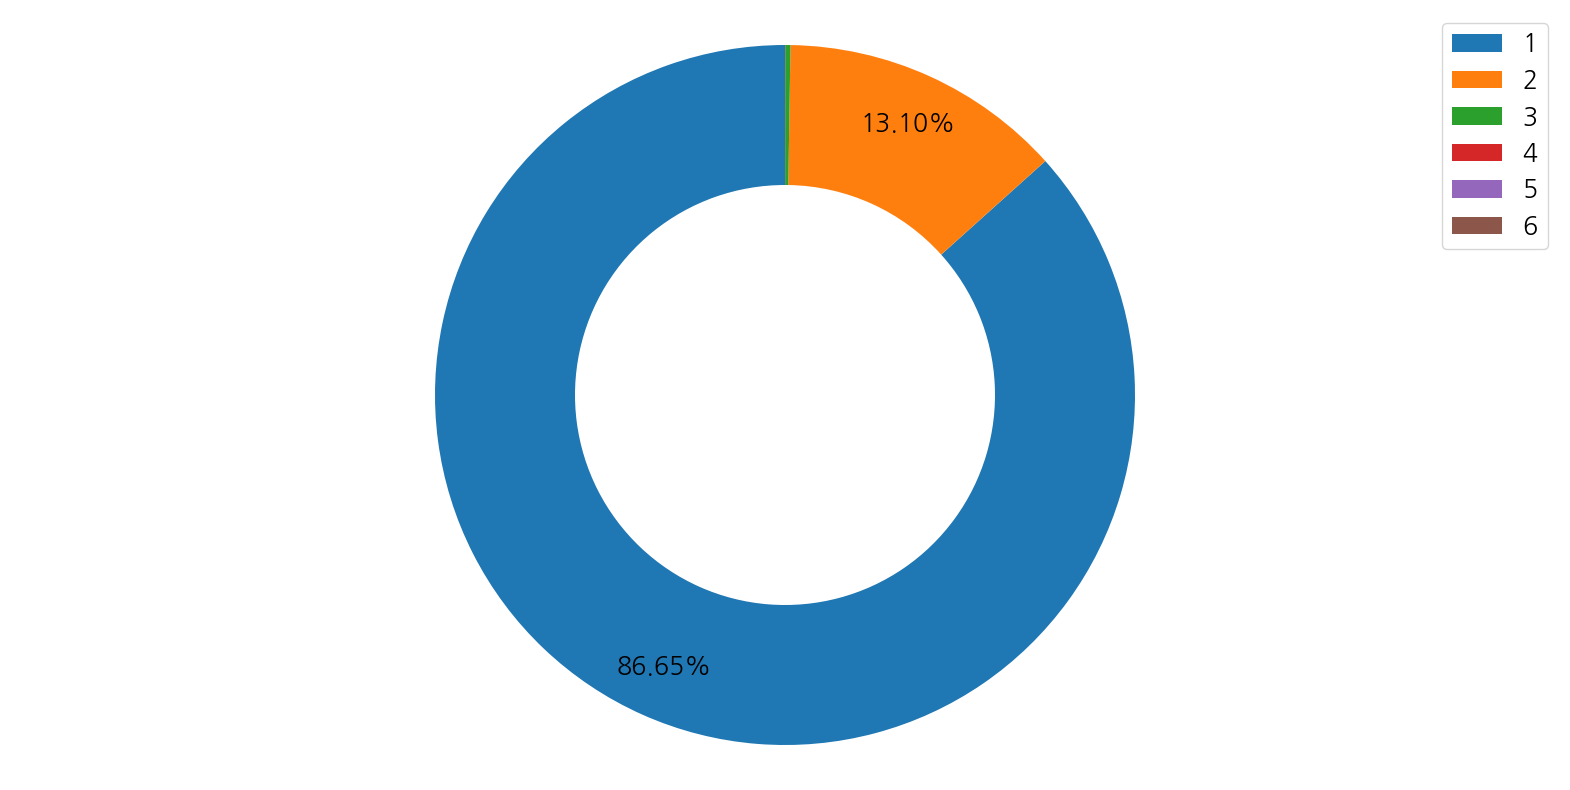

In [216]:
# plt.pie에 dataframe 형태로 들어가지 않으므로 수정
song_gnr_rate = gnr_song_count['비율(%)']
gnr_counts = gnr_song_count['매핑된 곡 수']
gnr_cnt = gnr_song_count['장르 수']

wed = {"width": 0.4}
plt.pie(song_gnr_rate, labels=None, wedgeprops=wed, startangle=90, autopct=lambda p: '{:.2f}%'.format(p) if p > 2 else '', pctdistance=0.85)

# 라벨 추가
plt.legend(gnr_cnt, loc='upper right')

plt.axis('equal')

- 많이 매핑되는 장르
    - POP장르의 곡 비중이 가장 높았고, 국악,뮤지컬,뮤직테라피, 종교음악등의 장르 비중은 1% 미만
    - 아이돌 아티스트 관련 장르인 아이돌 장르와 댄스 장르 비중도 비교적 낮음

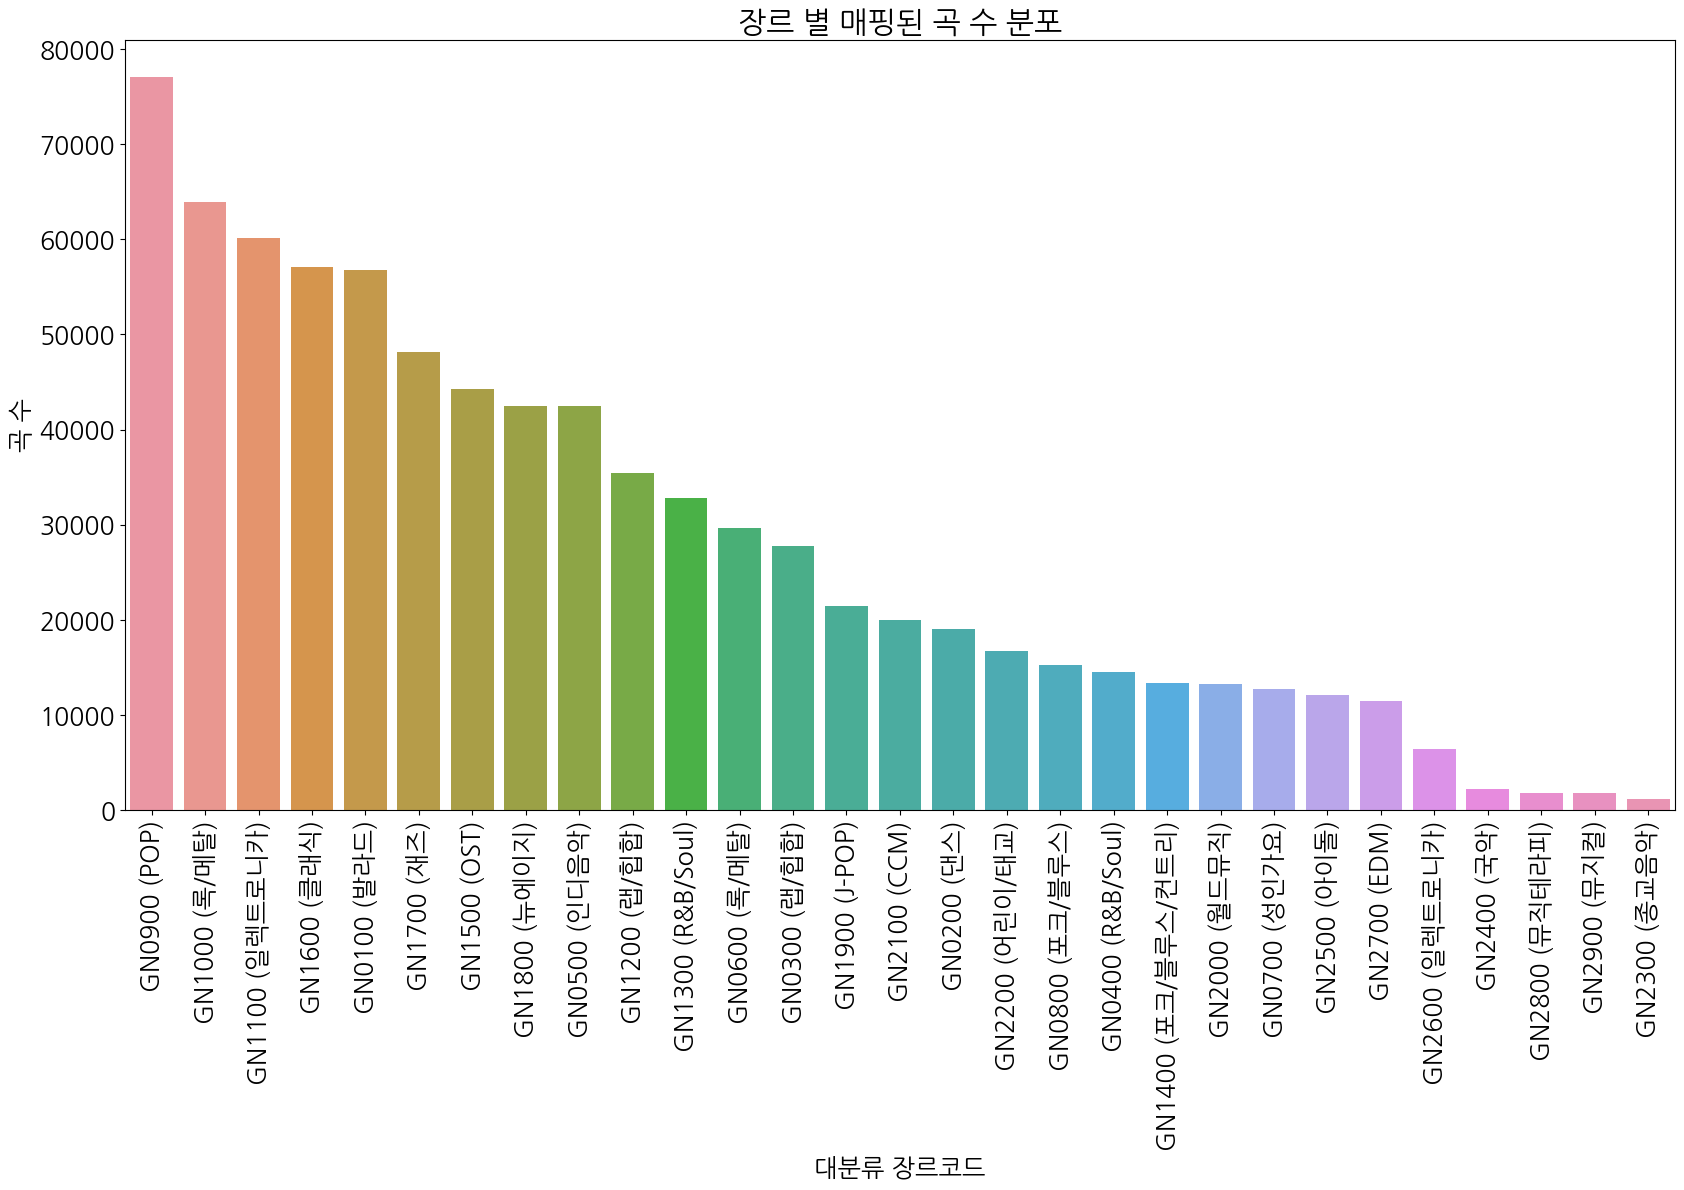

In [217]:
# 가장 많이 매핑되는 장르

gnr_count = song_gnr_map.groupby('gnr_code').song_id.nunique().reset_index(name = 'song_cnt')

# 2. 1번 테이블과 장르 meta와 join
gnr_count = pd.merge(gnr_count, gnr_code.loc[:, ['gnr_code', 'gnr_name']], how = 'left', on = 'gnr_code')
gnr_count['gnr_code_name'] = gnr_count['gnr_code'] + ' (' + gnr_count['gnr_name'] + ')'

# 3. 매핑이 되지 않은 일부 곡들은 제거
gnr_count = gnr_count[['gnr_code_name', 'song_cnt']].dropna()

# 4. 많은 곡이 매핑된 순 기준으로 내림차순 리스트 생성
gnr_list_desc = gnr_count.sort_values('song_cnt', ascending = False).gnr_code_name

# 5. plotting
gnr_code_name_plot = sns.barplot(x = 'gnr_code_name', y = 'song_cnt', data = gnr_count, order = gnr_list_desc)
gnr_code_name_plot.set_title('장르 별 매핑된 곡 수 분포')
gnr_code_name_plot.set_xlabel('대분류 장르코드')
gnr_code_name_plot.set_ylabel('곡 수')
plt.xticks(rotation = 90)
plt.show()

- 발매 년도 별 곡 추이
    - 2014~2019년도에 발매된 곡의 비중이 높았음 -> 49.89%
    - 1990~2020년도 발매된 곡이 전체 중 97.8% 차지



In [218]:
# 1. 곡 아이디(id)와 발매일자(issue_date) 추출
song_issue_date = song_meta[['id', 'issue_date']]
song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)

# 2. issue_date의 앞자리 네 자리를 추출하여 발매년도(issue_year) 변수 생성
song_issue_date['issue_year'] = song_issue_date['issue_date'].str[0:4]
song_issue_date.rename(columns = {'id' : 'song_id'}, inplace = True)
song_issue_date['song_id'] = song_issue_date['song_id'].astype(str)

song_issue_date[song_issue_date['issue_year'] == '0']
# 2,792개의 노래는 issue_year 정보 없음(issue_year가 0임)

C:\Users\cg063\AppData\Local\Temp\ipykernel_11320\1136109332.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)
C:\Users\cg063\AppData\Local\Temp\ipykernel_11320\1136109332.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_issue_date['issue_year'] = song_issue_date['issue_date'].str[0:4]
C:\Users\cg063\AppData\Local\Temp\ipykernel_11320\1136109332.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

,song_id,issue_date,issue_year
562,562,0,0
785,785,0,0
1543,1543,0,0
1730,1730,0,0
2360,2360,0,0
...,...,...,...
707473,707473,0,0
707483,707483,0,0
707515,707515,0,0
707738,707738,0,0


In [219]:
# issue_date(발매년도) 정보가 0인 행 제거
song_meta_issue_0 = song_meta[song_meta['issue_date'] == 0]
song_meta = song_meta.drop(song_meta_issue_0.index) 
song_meta.info() # 706155 -> 703363 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 703363 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  703363 non-null  object
 1   issue_date              703363 non-null  int64 
 2   album_name              703359 non-null  object
 3   album_id                703363 non-null  int64 
 4   artist_id_basket        703363 non-null  object
 5   song_name               703363 non-null  object
 6   song_gn_gnr_basket      703363 non-null  object
 7   artist_name_basket      703363 non-null  object
 8   id                      703363 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 53.7+ MB


In [220]:
# 새로운 song_meta 저장
song_meta.to_json('./origin_data_modify/song_meta_mod2.json')

In [221]:
song_meta = pd.read_json('./origin_data_modify/song_meta_mod2.json', typ = 'frame')
song_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 703363 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  703363 non-null  object
 1   issue_date              703363 non-null  int64 
 2   album_name              703359 non-null  object
 3   album_id                703363 non-null  int64 
 4   artist_id_basket        703363 non-null  object
 5   song_name               703363 non-null  object
 6   song_gn_gnr_basket      703363 non-null  object
 7   artist_name_basket      703363 non-null  object
 8   id                      703363 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 53.7+ MB


C:\Users\cg063\AppData\Local\Temp\ipykernel_11320\3464494275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)
C:\Users\cg063\AppData\Local\Temp\ipykernel_11320\3464494275.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_issue_date['issue_year'] = song_issue_date['issue_date'].str[0:4]
C:\Users\cg063\AppData\Local\Temp\ipykernel_11320\3464494275.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

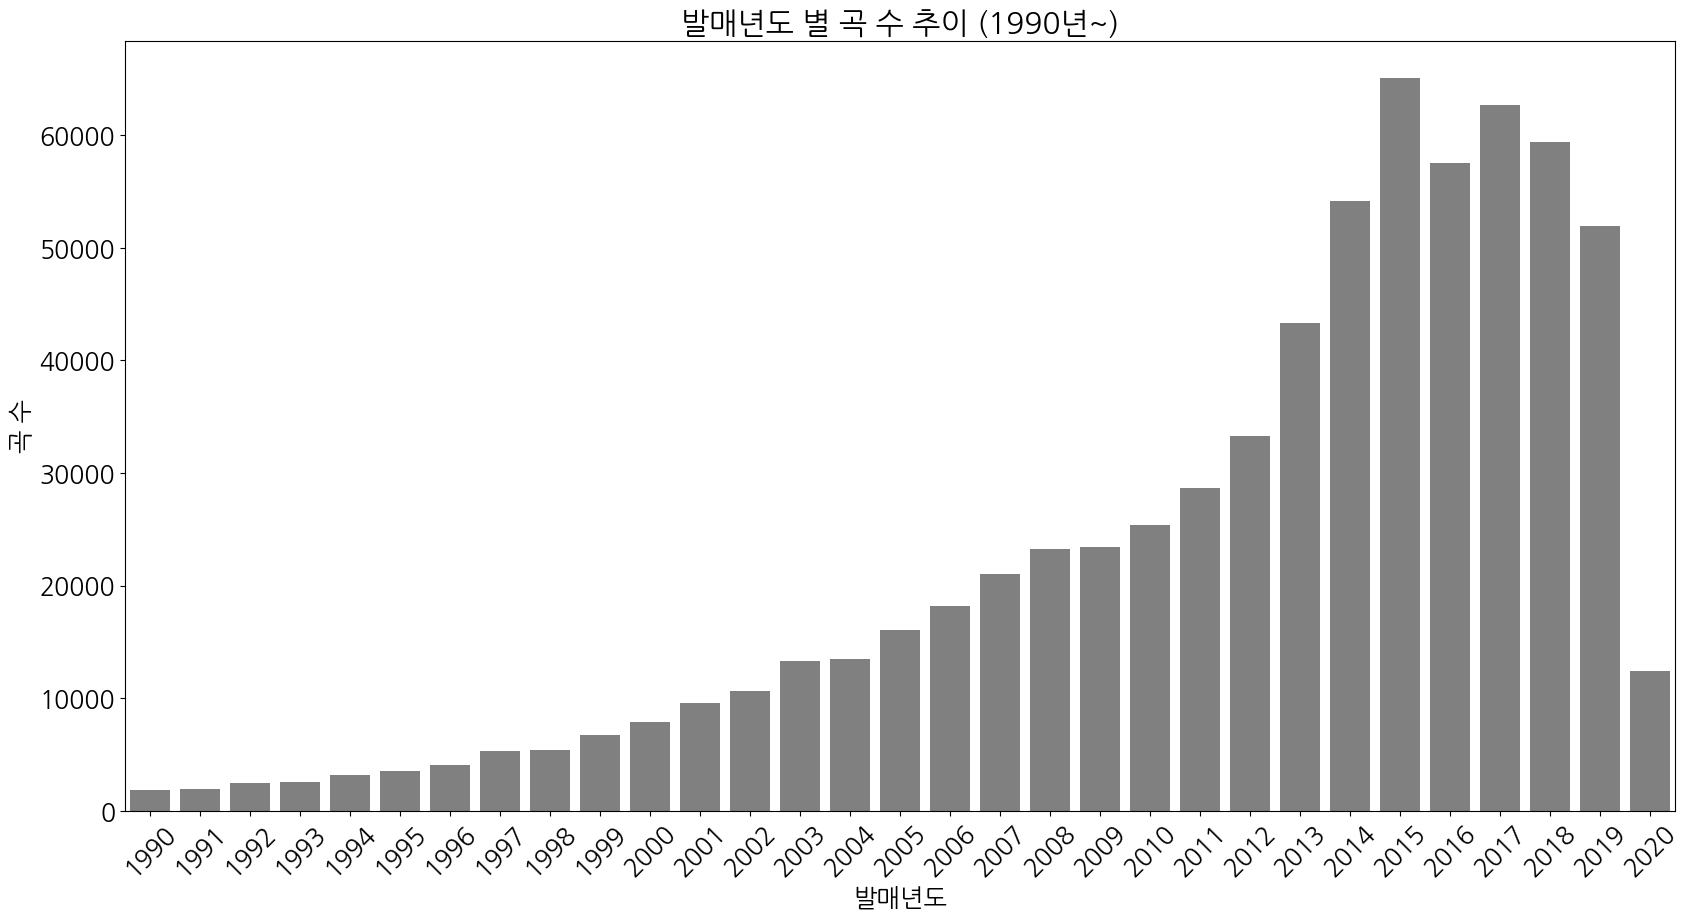

In [224]:
# 1. 곡 아이디(id)와 발매일자(issue_date) 추출
song_issue_date = song_meta[['id', 'issue_date']]
song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)

# 2. issue_date의 앞자리 네 자리를 추출하여 발매년도(issue_year) 변수 생성
song_issue_date['issue_year'] = song_issue_date['issue_date'].str[0:4]
song_issue_date.rename(columns = {'id' : 'song_id'}, inplace = True)
song_issue_date['song_id'] = song_issue_date['song_id'].astype(str)

# 3. 1990년도~ 필터링
song_issue_date_filter = song_issue_date[song_issue_date.issue_year >= '1990']

# 4. 발매년도 별 곡 수 count 테이블 생성 : issue_year_song_cnt
issue_year_song_cnt = song_issue_date_filter.groupby('issue_year').song_id.nunique().reset_index(name = 'song_cnt')

# 5. plotting
issue_year_song_cnt_plot = sns.barplot(x = 'issue_year', y = 'song_cnt', data = issue_year_song_cnt, color = 'grey')
issue_year_song_cnt_plot.set_title('발매년도 별 곡 수 추이 (1990년~)')
issue_year_song_cnt_plot.set_xlabel('발매년도')
issue_year_song_cnt_plot.set_ylabel('곡 수')
plt.xticks(rotation = 45)
plt.show()

In [226]:
song_issue_date_cnt = song_issue_date.groupby('issue_year')['song_id'].count().reset_index()
song_issue_date_cnt # 총 곡의 수 703363

,issue_year,song_id
0,1900,12
1,1919,4
2,1927,5
3,1931,1
4,1936,4
...,...,...
77,2016,57576
78,2017,62702
79,2018,59365
80,2019,51944


In [240]:
# 1990년도 전후 노래 비중 비교
old_song_cnt = song_issue_date_cnt[song_issue_date_cnt['issue_year'] < '1990']
print(old_song_cnt['song_id'].sum()) # 15449 -> 2.20%
young_song_cnt = song_issue_date_cnt[song_issue_date_cnt['issue_year'] >= '1990']
print(young_song_cnt['song_id'].sum()) #687914-> 97.8%
middle_song_cnt = song_issue_date_cnt.iloc[75:81, :]
print(middle_song_cnt['song_id'].sum()) #350903-> 49.89%

15449
687914
350903


### 2. train(플레이리스트) 관련

In [247]:
train = pd.read_json(path + 'train.json', typ = 'frame')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115071 entries, 0 to 115070
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tags          115071 non-null  object
 1   id            115071 non-null  int64 
 2   plylst_title  115071 non-null  object
 3   songs         115071 non-null  object
 4   like_cnt      115071 non-null  int64 
 5   updt_date     115071 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


In [248]:
# 플레이리스트 아이디(id)와 수록곡(songs) 추출
plylst_song_map = train[['id', 'songs']]

# unnest songs
plylst_song_map_unnest = np.dstack(
    (
        np.repeat(plylst_song_map.id.values, list(map(len, plylst_song_map.songs))), 
        np.concatenate(plylst_song_map.songs.values)
    )
)

# unnested 데이터프레임 생성 : plylst_song_map
plylst_song_map = pd.DataFrame(data = plylst_song_map_unnest[0], columns = plylst_song_map.columns)
plylst_song_map['id'] = plylst_song_map['id'].astype(str)
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)

# unnest 객체 제거
del plylst_song_map_unnest

plylst_song_map

,id,songs
0,61281,525514
1,61281,129701
2,61281,383374
3,61281,562083
4,61281,297861
...,...,...
5285866,100389,111365
5285867,100389,51373
5285868,100389,640239
5285869,100389,13759


- 단일 수록 : 299028
- 중복 수록 : 316114

In [249]:
# 1. 곡 별 수록된 플레이리스트 개수 count 테이블 생성 : song_plylst_cnt
song_plylst_cnt = plylst_song_map.groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 2. 단일/중복 수록 구분 : 곡 별 수록된 플레이리스트가 한 개면 '단일 수록', 두 개 이상이면 '중복 수록'
song_plylst_cnt = song_plylst_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(song_plylst_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['단일 수록', '중복 수록'])
)

# 3. 단일/중복 수록 구분 별 곡 수 count 테이블 생성 : song_plylst_mapping_division
song_plylst_mapping_division = pd.DataFrame(song_plylst_cnt.groupby('mapping_plylst_cnt_category').count())

# 4. 3번 테이블에 비율 값 추가
song_plylst_mapping_division.rename(columns = {'songs' : '곡 수'}, inplace = True)
song_plylst_mapping_division.loc[:, '비율(%)'] = round(song_plylst_mapping_division['곡 수']/sum(song_plylst_mapping_division['곡 수'])*100, 2)
song_plylst_mapping_division = song_plylst_mapping_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 수록 여부'})
song_plylst_mapping_division[['중복 수록 여부', '곡 수', '비율(%)']]

,중복 수록 여부,곡 수,비율(%)
0,단일 수록,299028,48.61
1,중복 수록,316114,51.39


- 유니크 곡 수 : 615142
- 유니크 태그 수 : 29160

In [250]:
# 플레이리스트 아이디(id)와 매핑된 태그(tags) 추출
plylst_tag_map = train[['id', 'tags']]

# unnest tags
plylst_tag_map_unnest = np.dstack(
    (
        np.repeat(plylst_tag_map.id.values, list(map(len, plylst_tag_map.tags))), 
        np.concatenate(plylst_tag_map.tags.values)
    )
)

# unnested 데이터프레임 생성 : plylst_tag_map
plylst_tag_map = pd.DataFrame(data = plylst_tag_map_unnest[0], columns = plylst_tag_map.columns)
plylst_tag_map['id'] = plylst_tag_map['id'].astype(str)

# unnest 객체 제거
del plylst_tag_map_unnest

plylst_tag_map

,id,tags
0,61281,락
1,10532,추억
2,10532,회상
3,76951,까페
4,76951,잔잔한
...,...,...
476326,131982,퇴근길
476327,100389,노래추천
476328,100389,팝송추천
476329,100389,팝송


In [251]:
train_uniq_song_cnt = plylst_song_map.songs.nunique() # 유니크 곡 수
train_uniq_tag_cnt = plylst_tag_map.tags.nunique() # 유니크 태그 수

print('곡 수 : %s' %train_uniq_song_cnt)
print('태그 수 : %s' %train_uniq_tag_cnt)

곡 수 : 615142
태그 수 : 29160


- 태그의 중복 매핑 여부
    - 단일 매핑 : 17431
    - 중복 매핑 : 11729

In [252]:
# 1. 태그 별 수록된 플레이리스트 개수 count 테이블 생성 : tag_plylst_cnt
tag_plylst_cnt = plylst_tag_map.groupby('tags').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 2. 단일/중복 매핑 구분 : 태그 별 매핑된 플레이리스트가 한 개면 '단일 매핑', 두 개 이상이면 '중복 매핑'
tag_plylst_cnt = tag_plylst_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(tag_plylst_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['단일 매핑', '중복 매핑'])
)

# 3. 단일/중복 매핑 구분 별 태그 수 count 테이블 생성 : tag_plylst_mapping_division
tag_plylst_mapping_division = pd.DataFrame(tag_plylst_cnt.groupby('mapping_plylst_cnt_category').count())

# 4. 3번 테이블에 비율 값 추가
tag_plylst_mapping_division.rename(columns = {'tags' : '태그 수'}, inplace = True)
tag_plylst_mapping_division.loc[:, '비율(%)'] = round(tag_plylst_mapping_division['태그 수']/sum(tag_plylst_mapping_division['태그 수'])*100, 2)
tag_plylst_mapping_division = tag_plylst_mapping_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 매핑 여부'})
tag_plylst_mapping_division[['중복 매핑 여부', '태그 수', '비율(%)']]

,중복 매핑 여부,태그 수,비율(%)
0,단일 매핑,17431,59.78
1,중복 매핑,11729,40.22


- 플레이리스트 별 곡/태그/장르 수 분포는?
    - 곡

- 각 플레이리스트 별 평균 약 46개의 곡이 수록되어 있음(중앙값 30개)
- 최대 200곡의 수록곡을 포함한 플레이리스트 존재(3,811개)

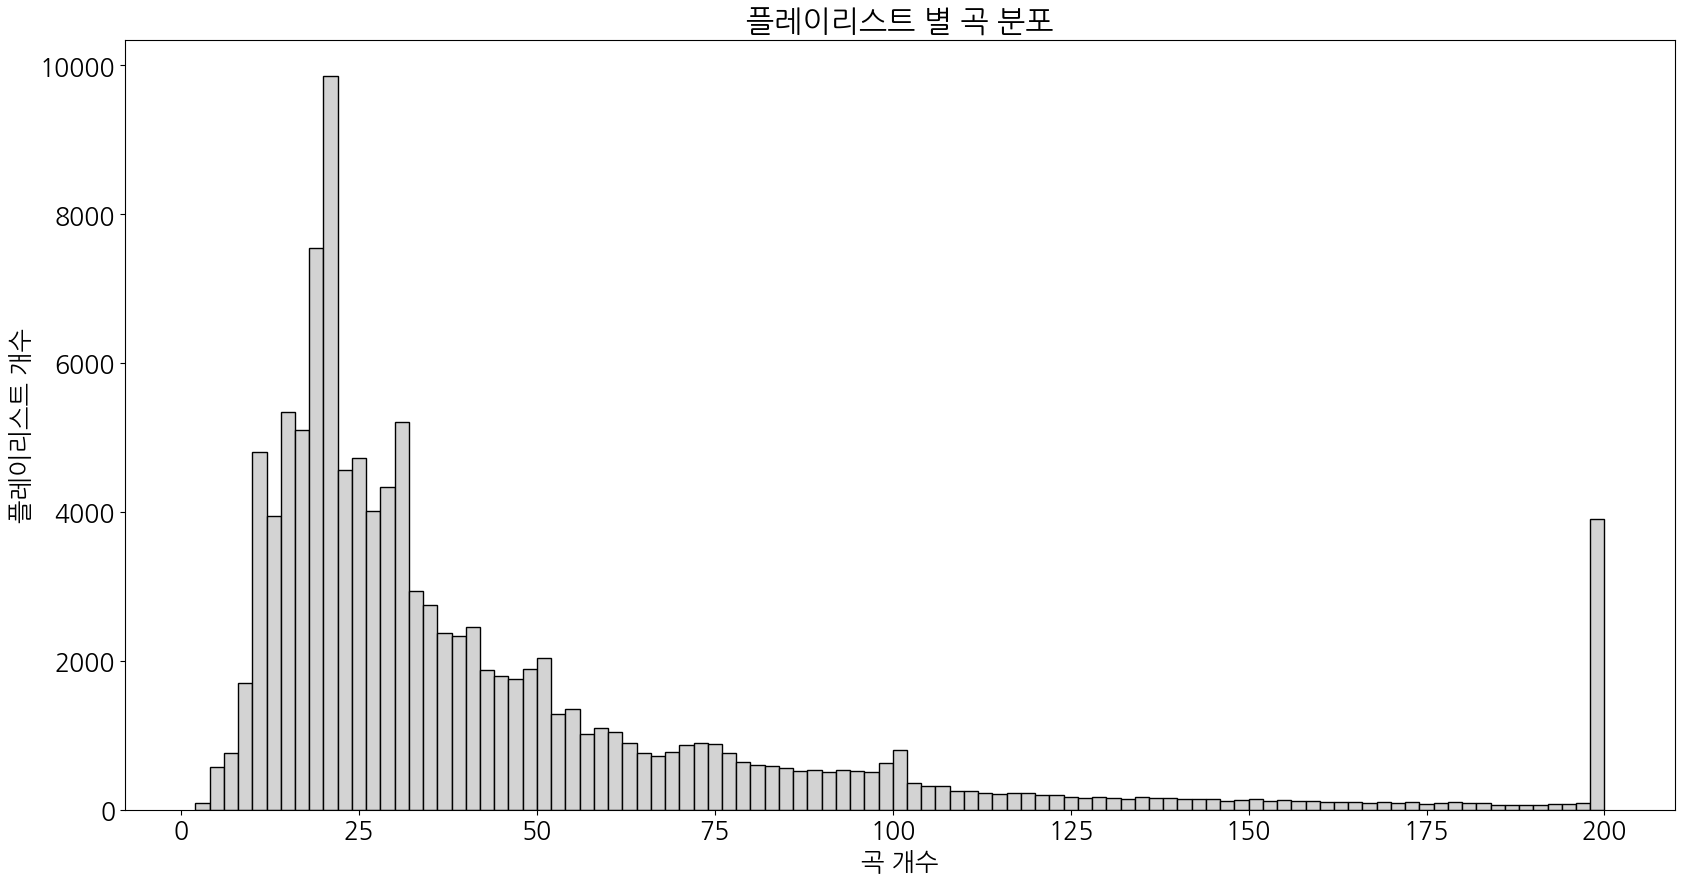

In [253]:
# 1. 플레이리스트 별 수록곡 수 count 테이블 생성 : plylst_song_cnt
plylst_song_cnt = pd.DataFrame(plylst_song_map.groupby('id').songs.nunique())

# 2-1. grid setting
grid_list = [i*2 for i in range(1, 101)]

# 2-2. plotting
plt.hist(plylst_song_cnt['songs'], grid_list, color = "lightgrey", edgecolor = "black")
plt.xlabel('곡 개수')
plt.ylabel('플레이리스트 개수')
plt.title('플레이리스트 별 곡 분포')
plt.show()

In [282]:
plylst_song_cnt['songs'].describe()

count    115071.000000
mean         45.935735
std          43.950335
min           1.000000
25%          19.000000
50%          30.000000
75%          54.000000
max         200.000000
Name: songs, dtype: float64

- 플레이리스트 별 곡/태그/장르 수 분포는?
    - 태그

- 각 플레이리스트 별 평균 약 4.1개의 곡이 수록되어 있음(중앙값 3개)
- 한 플레이리스트에 최대 11개의 태그가 사용됨
- 1개의 태그를 활용한 플레이리스트가 가장 많음 (23.67%)


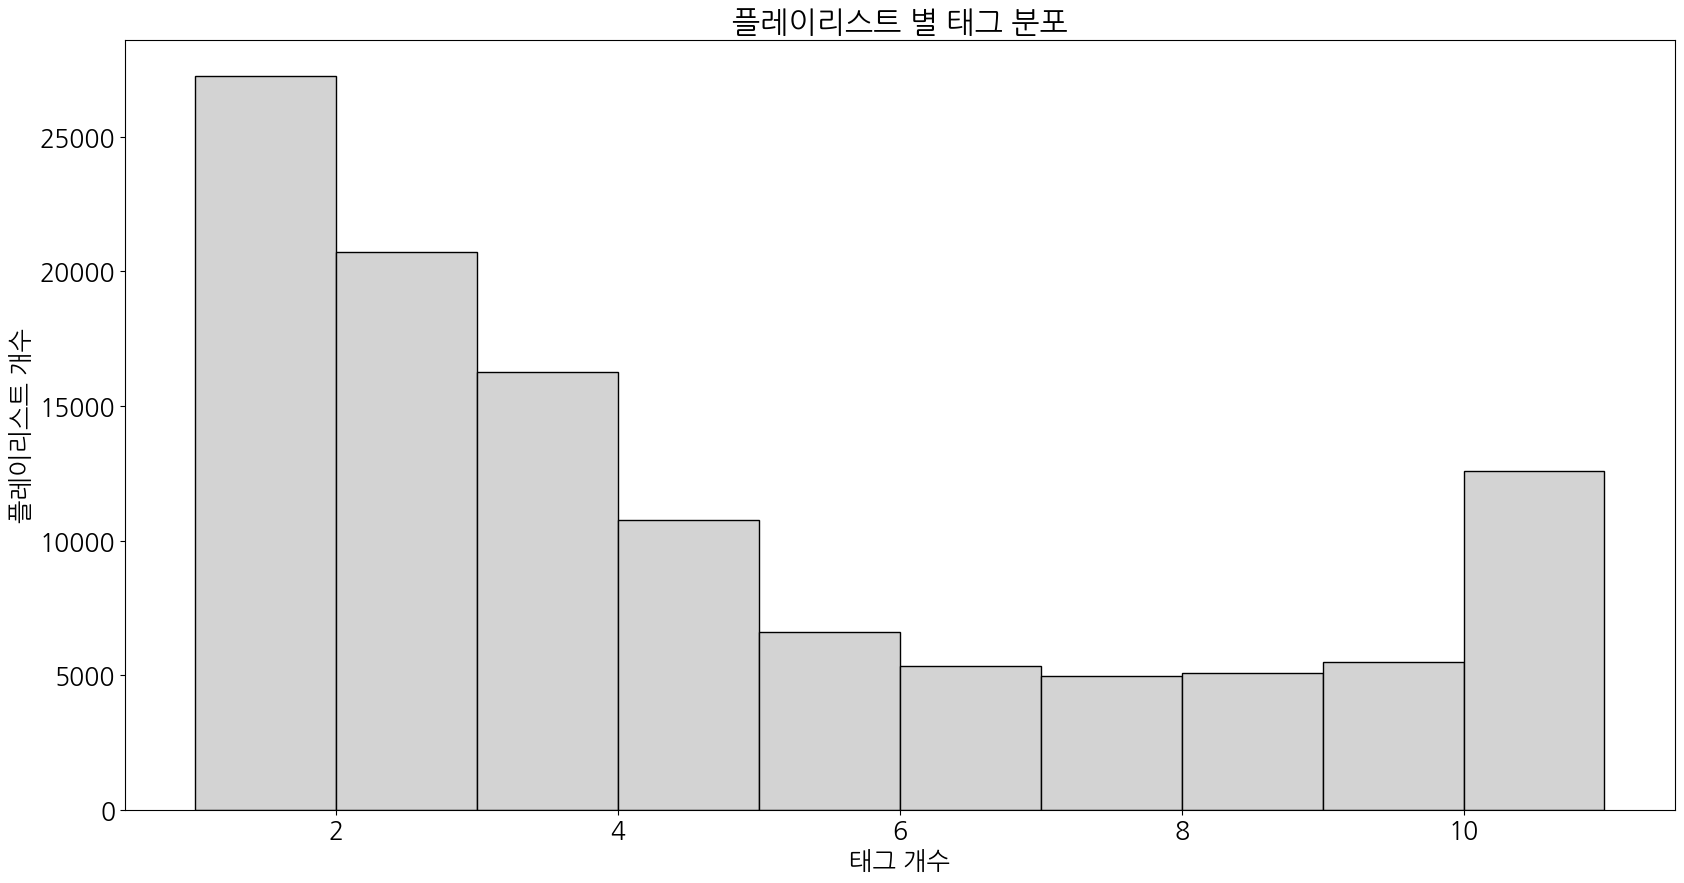

In [254]:
# 1. 플레이리스트 별 매핑 태그 수 count 테이블 생성 : plylst_tag_cnt
plylst_tag_cnt = pd.DataFrame(plylst_tag_map.groupby('id').tags.nunique())

# 2. plotting
plt.hist(plylst_tag_cnt['tags'], range(1, 12), color = "lightgrey", edgecolor = "black")
plt.xlabel('태그 개수')
plt.ylabel('플레이리스트 개수')
plt.title('플레이리스트 별 태그 분포')
plt.show()

In [285]:
plylst_tag_cnt['tags'].describe()

count    115071.000000
mean          4.139453
std           3.072261
min           1.000000
25%           2.000000
50%           3.000000
75%           6.000000
max          11.000000
Name: tags, dtype: float64

C:\Users\cg063\AppData\Local\Temp\ipykernel_11320\3146213702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tag_cnt['tag_cnt'] = train_tag_cnt['tags'].apply(lambda x : len(x))


(-1.0999994672159232,
 1.0999999741454027,
 -1.0999998041877093,
 1.0999999906756053)

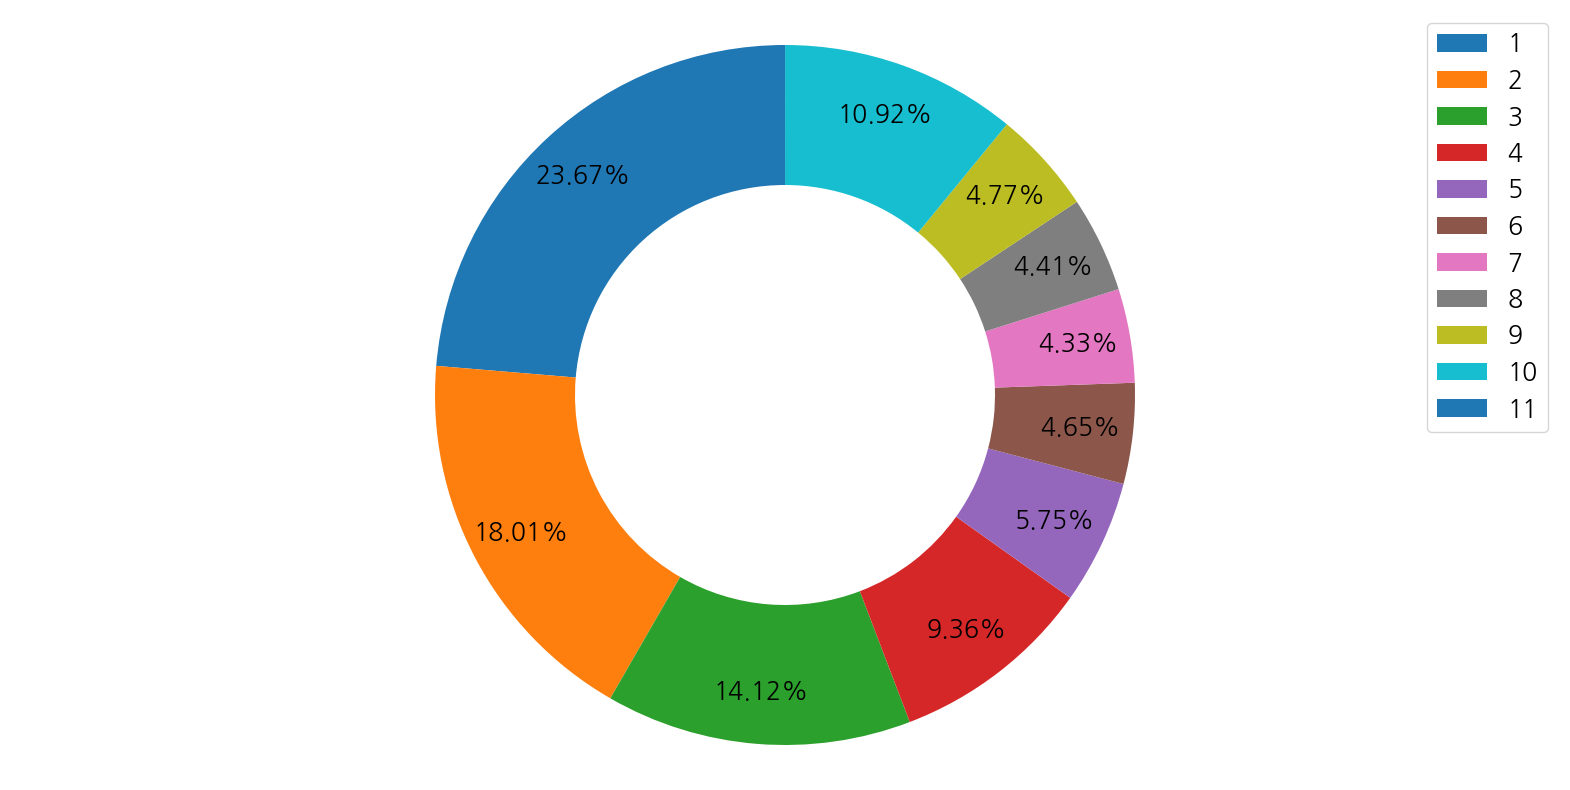

In [258]:
train_tag_cnt = train[['id', 'tags']]
train_tag_cnt['tag_cnt'] = train_tag_cnt['tags'].apply(lambda x : len(x))
train_tag_cnt = train_tag_cnt.groupby('tag_cnt')['id'].count().reset_index()
train_tag_cnt['tag_cnt_rate'] = train_tag_cnt['id'].apply(lambda x : x/sum(train_tag_cnt['id'])*100)

train_tag_cnt_x = list(train_tag_cnt['tag_cnt_rate'])
tag_cnt_legend = list(train_tag_cnt['tag_cnt'])

wed = {"width": 0.4}
plt.pie(train_tag_cnt_x, labels=None, wedgeprops=wed, startangle=90, autopct=lambda p: '{:.2f}%'.format(p) if p > 2 else '', pctdistance=0.85)

# 라벨 추가
plt.legend(tag_cnt_legend, loc='upper right')

plt.axis('equal')

- 플레이리스트 별 곡/태그/장르 수 분포는?
    - 장르

- 각 플레이리스트 별 평균 약 6.6개의 대분류 장르를 포함(중앙값 6개)
- 최대 25개의 장르를 포함한 플레이리스트 존재

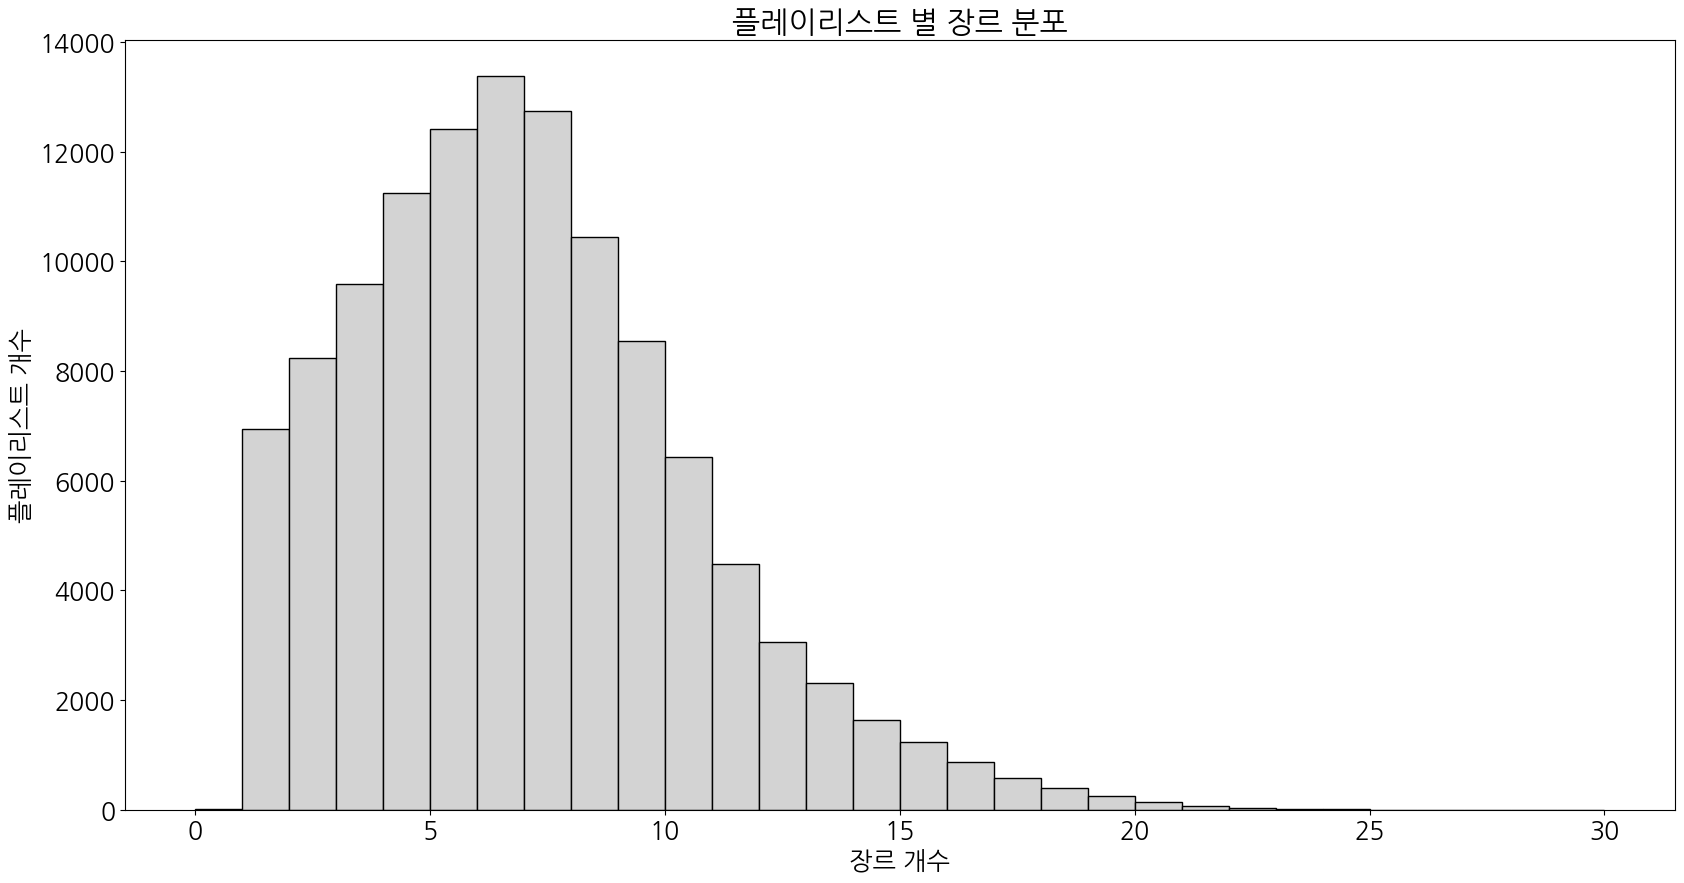

In [259]:
# 1-1. join 목적으로 곡 아이디 integer to string 변환
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)

# 1-2. 플레이리스트-곡 테이블 plylst_song_map + 곡-장르 테이블 song_gnr_map join
plylst_song_gnr_map = pd.merge(plylst_song_map, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 2. 플레이리스트 별 곡 장르 수 count 테이블 생성 : plylst_song_gnr_cnt
plylst_song_gnr_cnt = pd.DataFrame(plylst_song_gnr_map.groupby('id').gnr_code.nunique())

# 3. plotting
plt.hist(plylst_song_gnr_cnt['gnr_code'], range(0, 31), color = "lightgrey", edgecolor = "black")
plt.xlabel('장르 개수')
plt.ylabel('플레이리스트 개수')
plt.title('플레이리스트 별 장르 분포')
plt.show()

In [286]:
plylst_song_gnr_cnt['gnr_code'].describe()

count    115071.000000
mean          6.536816
std           3.617114
min           0.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          25.000000
Name: gnr_code, dtype: float64

- 플레이리스트의 중복 수록곡 중 TOP30

In [260]:
# 1. song_plylst_cnt 테이블에서 중복 수록 곡 중 수록 횟수 기준 상위 30곡 필터링 테이블 생성 : duplicate_song_top30
duplicate_song_top30 = song_plylst_cnt[song_plylst_cnt['mapping_plylst_cnt_category'] == '중복 수록'].nlargest(30, 'mapping_plylst_cnt')

# 2-1. join 목적으로 곡 아이디 integer to string 변환
duplicate_song_top30['songs'] = duplicate_song_top30['songs'].astype(str)
song_meta['id'] = song_meta['id'].astype(str)

# 2-2 상위 30곡 테이블 duplicate_song_top30 + 곡 메타 song_meta join
top_30 = pd.merge(duplicate_song_top30, song_meta[['id', 'song_name', 'artist_name_basket']],how = 'left', left_on = 'songs', right_on = 'id')[['songs', 'song_name', 'artist_name_basket', 'mapping_plylst_cnt']].rename(columns = {'songs' : '곡 아이디', 'song_name' : '곡 명', 'artist_name_basket' : '아티스트 명', 'mapping_plylst_cnt' : '수록 횟수'})

top_30

,곡 아이디,곡 명,아티스트 명,수록 횟수
0,144663,밤편지,[아이유],2175
1,116573,안아줘,[정준일],2121
2,357367,비,[폴킴],1981
3,366786,가끔 미치도록 네가 안고 싶어질 때가 있어,[가을방학],1919
4,654757,눈의 꽃,[박효신],1647
5,133143,"그대와 나, 설레임 (Feat. 소울맨)",[어쿠스틱 콜라보],1633
6,349492,어떤이별,[임승부],1599
7,675115,야생화,[박효신],1598
8,463173,비가 내렸어 (Vocal by 스티브언니),[업라이트 (Upright)],1544
9,42155,벙어리,[홍아],1540


- 플레이리스트의 단일 수록곡 중 TOP30

In [261]:
# 1. song_plylst_cnt 테이블에서 단일 수록 곡만 필터링 하여 테이블 생성 : single_song
single_song = song_plylst_cnt[song_plylst_cnt['mapping_plylst_cnt_category'] == '단일 수록']

# 2-1. join 목적으로 곡 아이디 integer to string 변환
single_song['songs'] = single_song['songs'].astype(str)

# 2-2. 단일 수록 곡 테이블 single_song + 곡 메타 song_meta join : 아티스트 기준 single_song_artist, 장르 기준 single_song_gnr
single_song_artist = pd.merge(single_song, song_meta[['id', 'song_name', 'artist_name_basket']], how = 'left', left_on = 'songs', right_on = 'id')
single_song_gnr = pd.merge(single_song, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 3. 수록 곡 개수 기준 상위 30개 장르 : single_song_gnr_cnt
single_song_gnr_cnt = single_song_gnr.groupby('gnr_code').songs.nunique().reset_index(name = 'song_cnt')
single_top30 = pd.merge(single_song_gnr_cnt, genre_gn_all, how = 'left', on = 'gnr_code')[['gnr_code', 'gnr_name', 'song_cnt']].rename(columns = {'gnr_code' : '대분류 장르코드', 'gnr_name' : '장르명', 'song_cnt' : '수록 곡 수'}).sort_values('수록 곡 수', ascending = False)

single_top30

C:\Users\cg063\AppData\Local\Temp\ipykernel_11320\3025619736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_song['songs'] = single_song['songs'].astype(str)


,대분류 장르코드,장르명,수록 곡 수
15,GN1600,클래식,32841
8,GN0900,POP,30987
9,GN1000,록/메탈,30028
10,GN1100,일렉트로니카,25725
16,GN1700,재즈,23158
17,GN1800,뉴에이지,19370
14,GN1500,OST,16855
11,GN1200,랩/힙합,15054
0,GN0100,발라드,14575
12,GN1300,R&B/Soul,13136


- 빈도수 높은 태그
    - 기분전환 태그명이 가장 높은 비중 차지 (1,000번 이상 매핑된 태그 기준)
    - 계절이나 드라이브, 카페, 매장음악 등 특정 상황과 어울리는 태그 등이 상위권 분포
    - 발라드, 힙합, 인디, 락, 댄스, 뉴에이지 등 장르 관련 태그도 일부 상윅권 포함


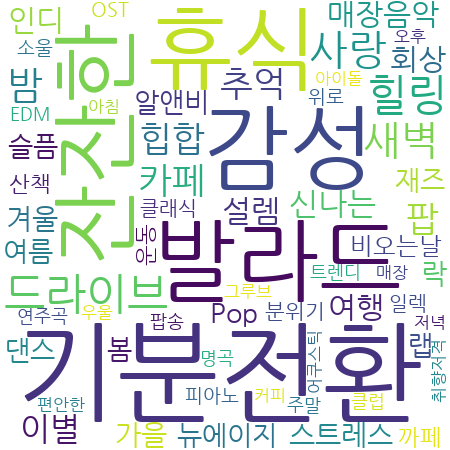

In [262]:
# 태그 별 매핑 빈도 수 저장 
tag_cnt = plylst_tag_map.groupby('tags').tags.count().reset_index(name = 'mapping_cnt')
tag_cnt['tags'] = tag_cnt['tags'].astype(str)
tag_cnt['mapping_cnt'] = tag_cnt['mapping_cnt'].astype(int)

# 빈도 수가 1000회 이상인 태그만 저장
tag_cnt = tag_cnt[tag_cnt['mapping_cnt'] >= 1000]
word_count = list(zip(tag_cnt['tags'], tag_cnt['mapping_cnt']))

# plotting
wc = WordCloud(font_path = './res/NanumGothic.ttf', background_color = 'white', max_words = 100, width = 450, height = 450)
wc.generate_from_frequencies(dict(word_count)).to_image()

- 플레이리스트에 매핑된 TOP30 태그리스트
    - 다른 태그와 조합 없는 장르 관련 태그가 상위권을 차지하고 있으며, 발라드 단일 태그가 가장 많았음
    - 기분전환 태그명은 휴식, 힐링 뿐만 아니라 스트레스, 드라이브, 사랑, 설렘 등 다양한 태그와 같이 조합을 이루는 케이스가 많았음


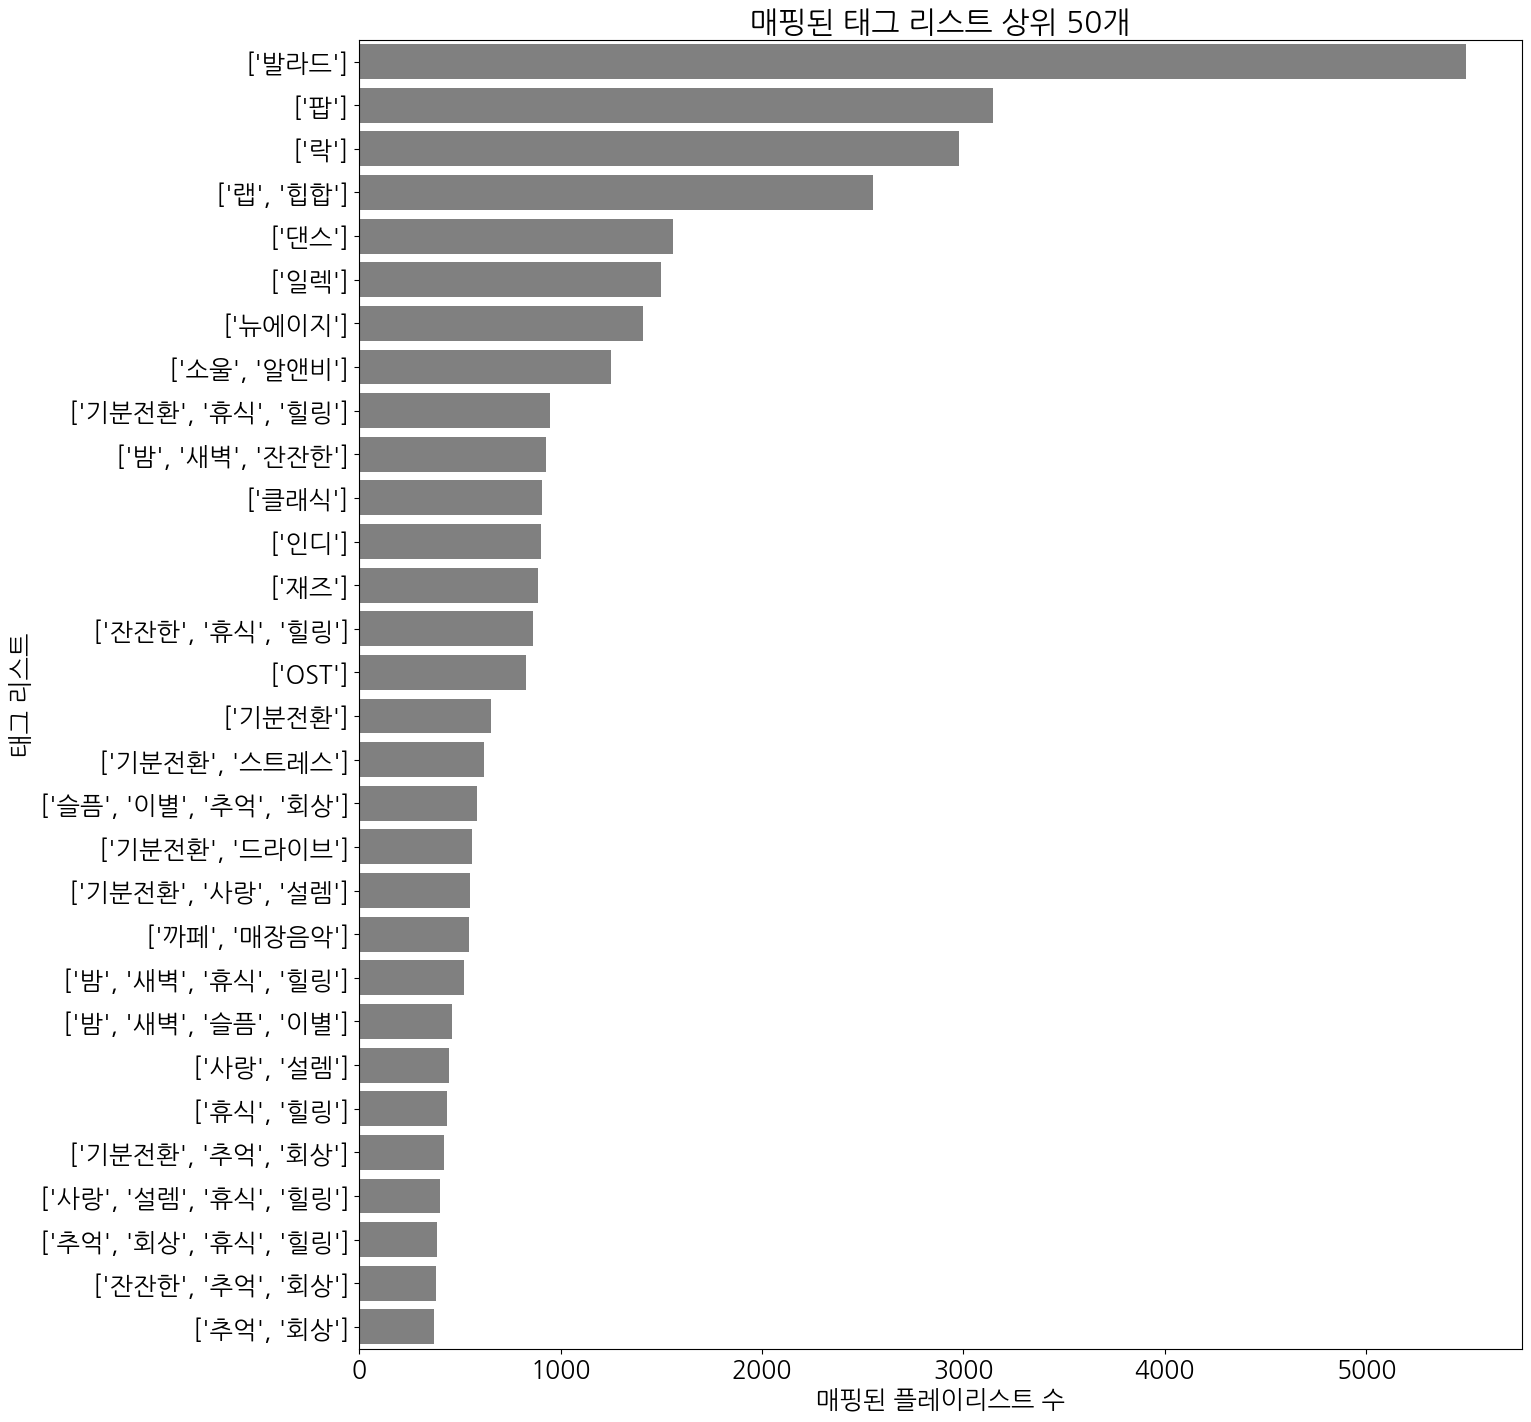

In [263]:
# 1. unnest 데이터프레임인 plylst_tag_map 테이블에서 태그 이름 정렬 후 list로 묶기
plylst_tag_list_sort = plylst_tag_map.sort_values(by = ['id', 'tags']).groupby('id').tags.apply(list).reset_index(name = 'tag_list')

# 2. 집계를 위해 1번 테이블에서 list 타입을 문자열 타입으로 변경
plylst_tag_list_sort['tag_list'] = plylst_tag_list_sort['tag_list'].astype(str)

# 3. 태그 리스트 별 매핑되는 플레이리스트 수 집계 테이블 생성 : tag_list_plylst_cnt
tag_list_plylst_cnt = plylst_tag_list_sort.groupby('tag_list').id.nunique().reset_index(name = 'plylst_cnt')

# 4. 매핑 수 기준 상위 50개 필터링
tag_list_plylst_cnt = tag_list_plylst_cnt.nlargest(30, 'plylst_cnt')

# 5. plotting
plt.figure(figsize = (15, 17))
tag_list_plylst_cnt_plot = sns.barplot(y = 'tag_list', x = 'plylst_cnt', data = tag_list_plylst_cnt, color = 'grey')
tag_list_plylst_cnt_plot.set_title('매핑된 태그 리스트 상위 50개')
tag_list_plylst_cnt_plot.set_xlabel('매핑된 플레이리스트 수')
tag_list_plylst_cnt_plot.set_ylabel('태그 리스트')
plt.show()

- 플레이리스트 태그 별 수록된 곡
    - 드라이브, 스트레스, 기분전환 태그가 매핑된 플레이리스트와 카페, 매장음악 태그가 매핑된 플레이리스트에서는 팝, 일렉 장르가 가장 많았음
    - 그 외에도 발라드 곡 비중이 가장 높았으며, 슬픔, 이별 태그가 매핑된 플레이리스트에서는 발라드 비중이 가장 높았음
    - 밤, 새벽, 잔잔한, 휴식, 힐링 등의 태그가 있는 플레이리스트에서는 발라드 다음으로 팝 비중이 높았음
추억, 회상 태그가 매핑된 플레이리스트에서는 OST 비중이 발라드 다음으로 높음

        => 플레이리스트 수록곡 특징을 탐색해 플레이리스트의 곡 장르 성격 추정 가능

In [264]:
# 1. 플레이리스트-곡 테이블 plylst_song_map + 플레이리스트-태그 테이블 plylst_tag_map join 테이블 생성 : plylst_song_tag_map
plylst_song_tag_map = pd.merge(plylst_song_map, plylst_tag_map, how = 'left', on = 'id')

# 2. 1번 테이블 plylst_song_tag_map + 곡 장르 테이블 song_gnr_map join
plylst_song_tag_map = pd.merge(plylst_song_tag_map, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 3. 2번 테이블에서 장르 메타 join
gnr_code['gnr_code_name'] = gnr_code['gnr_code'] + ' (' + gnr_code['gnr_name'] + ')'
gnr_code = gnr_code[['gnr_code', 'gnr_code_name']]
plylst_song_tag_map = pd.merge(plylst_song_tag_map, gnr_code, how = 'left', on = 'gnr_code')

# 4. 최종 테이블 필드 선택
plylst_song_tag_map = plylst_song_tag_map[['id', 'songs', 'tags', 'gnr_code_name']]

In [265]:
# 태그 = ['드라이브', '스트레스', '기분전환']
song_tag_map_sample_1 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['드라이브', '스트레스', '기분전환']), :]
# 태그 = ['밤', '새벽', '잔잔한']
song_tag_map_sample_2 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['밤', '새벽', '잔잔한']), :]
# 태그 = ['사랑', '설렘']
song_tag_map_sample_3 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['사랑', '설렘']), :]
# 태그 = ['추억', '회상']
song_tag_map_sample_4 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['추억', '회상']), :]
# 태그 = ['슬픔', '이별']
song_tag_map_sample_5 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['슬픔', '이별']), :]
# 태그 = ['휴식', '힐링']
song_tag_map_sample_6 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['휴식', '힐링']), :]
# 태그 = ['휴식', '힐링']
song_tag_map_sample_7 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['카페', '매장음악']), :]

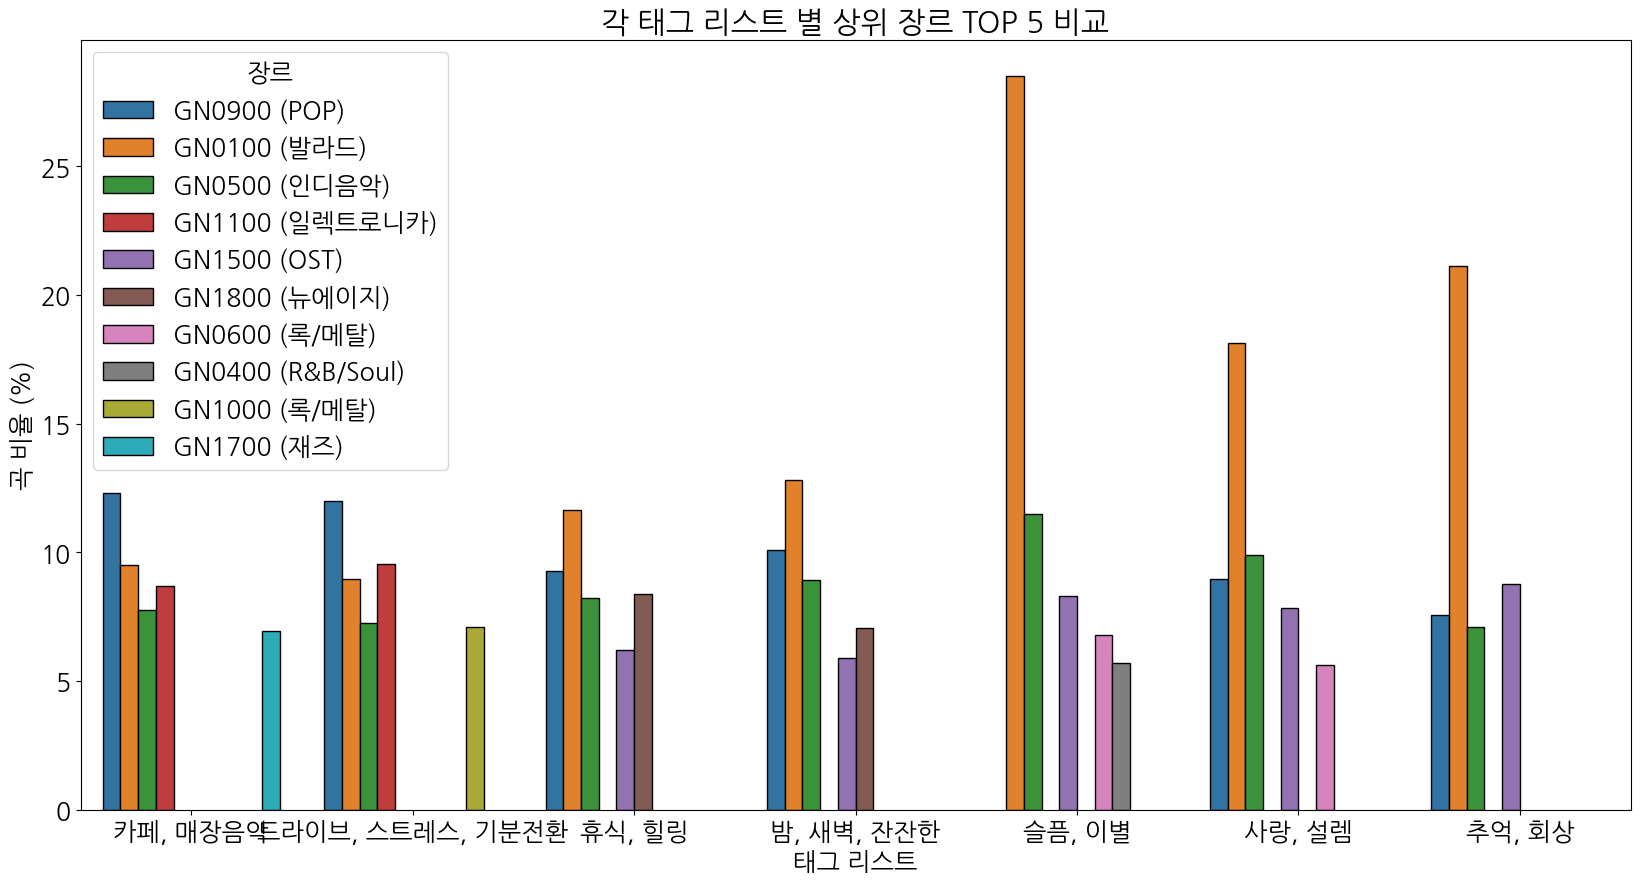

In [266]:
# 각 샘플 태그 리스트 별 장르 비율 집계
song_tag_map_sample_1_gnr_rank = song_tag_map_sample_1.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_1_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_1_gnr_rank['song_cnt']/sum(song_tag_map_sample_1_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_1_gnr_rank['gnr_rank'] = song_tag_map_sample_1_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_1_gnr_rank['tag_list'] = '드라이브, 스트레스, 기분전환'
song_tag_map_sample_1_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_2_gnr_rank = song_tag_map_sample_2.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_2_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_2_gnr_rank['song_cnt']/sum(song_tag_map_sample_2_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_2_gnr_rank['gnr_rank'] = song_tag_map_sample_2_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_2_gnr_rank['tag_list'] = '밤, 새벽, 잔잔한'
song_tag_map_sample_2_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_3_gnr_rank = song_tag_map_sample_3.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_3_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_3_gnr_rank['song_cnt']/sum(song_tag_map_sample_3_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_3_gnr_rank['gnr_rank'] = song_tag_map_sample_3_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_3_gnr_rank['tag_list'] = '사랑, 설렘'
song_tag_map_sample_3_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_4_gnr_rank = song_tag_map_sample_4.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_4_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_4_gnr_rank['song_cnt']/sum(song_tag_map_sample_4_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_4_gnr_rank['gnr_rank'] = song_tag_map_sample_4_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_4_gnr_rank['tag_list'] = '추억, 회상'
song_tag_map_sample_4_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_5_gnr_rank = song_tag_map_sample_5.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_5_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_5_gnr_rank['song_cnt']/sum(song_tag_map_sample_5_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_5_gnr_rank['gnr_rank'] = song_tag_map_sample_5_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_5_gnr_rank['tag_list'] = '슬픔, 이별'
song_tag_map_sample_5_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_6_gnr_rank = song_tag_map_sample_6.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_6_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_6_gnr_rank['song_cnt']/sum(song_tag_map_sample_6_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_6_gnr_rank['gnr_rank'] = song_tag_map_sample_6_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_6_gnr_rank['tag_list'] = '휴식, 힐링'
song_tag_map_sample_6_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_7_gnr_rank = song_tag_map_sample_7.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_7_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_7_gnr_rank['song_cnt']/sum(song_tag_map_sample_7_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_7_gnr_rank['gnr_rank'] = song_tag_map_sample_7_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_7_gnr_rank['tag_list'] = '카페, 매장음악'
song_tag_map_sample_7_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

# delete object
del song_tag_map_sample_1, song_tag_map_sample_2, song_tag_map_sample_3, song_tag_map_sample_4, song_tag_map_sample_5, song_tag_map_sample_6, song_tag_map_sample_7

# row binding
song_tag_map_sample_rbind = pd.concat(
    [song_tag_map_sample_1_gnr_rank, song_tag_map_sample_2_gnr_rank, song_tag_map_sample_3_gnr_rank,
     song_tag_map_sample_4_gnr_rank, song_tag_map_sample_5_gnr_rank, song_tag_map_sample_6_gnr_rank,
     song_tag_map_sample_7_gnr_rank],
    axis = 0
)

# plotting
song_tag_map_sample_rbind_plot = sns.barplot(
    data = song_tag_map_sample_rbind.loc[song_tag_map_sample_rbind['순위'] <= 5, :].sort_values(by = '순위'),
    x = '태그 리스트', y = '비율(%)', hue = '장르', edgecolor = "black"
)
song_tag_map_sample_rbind_plot.set_title('각 태그 리스트 별 상위 장르 TOP 5 비교')
song_tag_map_sample_rbind_plot.set_xlabel('태그 리스트')
song_tag_map_sample_rbind_plot.set_ylabel('곡 비율 (%)')
plt.show()

- 발매년도 기준으로 태그 사용률

    - 추억, 회상이 매핑된 플레이리스트들은 태그명처럼 다른 플레이리스트에 비해 비교적 과거 발매 곡 비중이 조금 더 높은 편을 확인할 수 있음
    - 2010년대 초반 ‘사랑, 설렘‘의 태그 사용률이 가장 높았으며, 2010년대 중반 이후 ‘카페, 매장음악‘ 사용률이 급격히 증가함


C:\Users\cg063\AppData\Local\Temp\ipykernel_11320\101834773.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plylst_song_tag_map_issue_year_filter['issue_year'] = plylst_song_tag_map_issue_year_filter['issue_year'].apply(pd.to_numeric)
C:\Users\cg063\AppData\Local\Temp\ipykernel_11320\101834773.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp_df['issue_year'], hist = False, kde = 

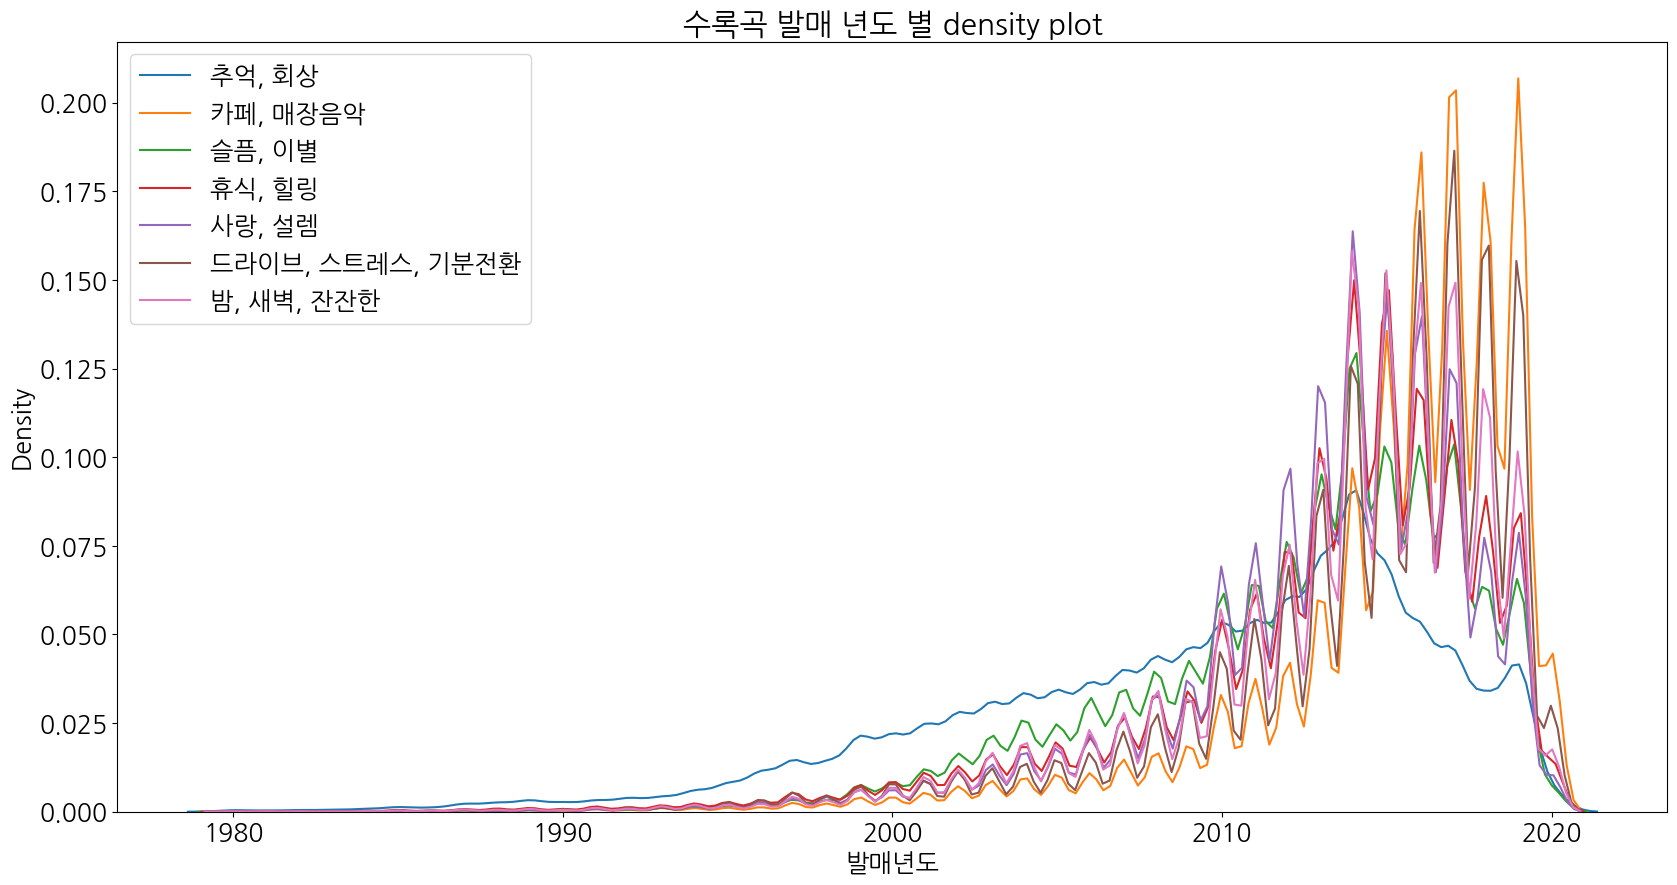

In [267]:
# 위에서 생성한 테이블에서 곡 별 발매년도 join
plylst_song_tag_map_issue_year = pd.merge(plylst_song_tag_map, song_issue_date, how = 'left', left_on = 'songs', right_on = 'song_id')

# 샘플 태그들이 포함되어 있는 플레이리스트만 필터링
plylst_song_tag_map_issue_year_filter = plylst_song_tag_map_issue_year.loc[plylst_song_tag_map_issue_year.tags.isin(['드라이브', '스트레스', '기분전환', '밤', '새벽', '잔잔한', '사랑', '설렘', '추억', '회상', '슬픔', '이별', '휴식', '힐링', '카페', '매장음악']), :]
plylst_song_tag_map_issue_year_filter['issue_year'] = plylst_song_tag_map_issue_year_filter['issue_year'].apply(pd.to_numeric)
plylst_song_tag_map_issue_year_filter = plylst_song_tag_map_issue_year_filter[plylst_song_tag_map_issue_year_filter['issue_year'] >= 1980]

del plylst_song_tag_map_issue_year

# plotting
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['추억', '회상']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '추억, 회상')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['카페', '매장음악']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '카페, 매장음악')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['슬픔', '이별']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '슬픔, 이별')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['휴식', '힐링']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '휴식, 힐링')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['사랑', '설렘']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '사랑, 설렘')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['드라이브', '스트레스', '기분전환']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '드라이브, 스트레스, 기분전환')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['밤', '새벽', '잔잔한']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '밤, 새벽, 잔잔한')
plt.legend(prop = {'size' : 18})
plt.title('수록곡 발매 년도 별 density plot')
plt.xlabel('발매년도')
plt.ylabel('Density')
plt.show()

- 각 song별 플레이리스트에 사용된 횟수
    
    - 대부분의 곡들이 1번만 플레이리스트에 포함됐음
    - 1회 포함 비율 : 48.61%
    - 10회 이상 포함 비율 : 12.63%


In [268]:
from collections import Counter

all_sogs = [song for sublist in train['songs'] for song in sublist]

all_sogs
song_counts = Counter(all_sogs)
song_counts_df = pd.DataFrame.from_dict(song_counts, orient='index', columns=['등장횟수'])

# 인덱스의 이름 설정
song_counts_df.index.name = 'song'
song_counts_df.reset_index(inplace=True)

# 등장 횟수를 기준으로 그룹화
grouped = song_counts_df.groupby('등장횟수').size().reset_index(name='곡 수')
grouped['비율'] = grouped['곡 수'].apply(lambda x: x/sum(grouped['곡 수'])*100)
grouped['비율'] = grouped['비율'].round(2)
grouped

,등장횟수,곡 수,비율
0,1,299028,48.61
1,2,94458,15.36
2,3,47587,7.74
3,4,29395,4.78
4,5,20048,3.26
...,...,...,...
952,1647,1,0.00
953,1919,1,0.00
954,1981,1,0.00
955,2121,1,0.00


In [269]:
grouped.iloc[:10, :]

,등장횟수,곡 수,비율
0,1,299028,48.61
1,2,94458,15.36
2,3,47587,7.74
3,4,29395,4.78
4,5,20048,3.26
5,6,14815,2.41
6,7,11521,1.87
7,8,9388,1.53
8,9,7681,1.25
9,10,6143,1.00


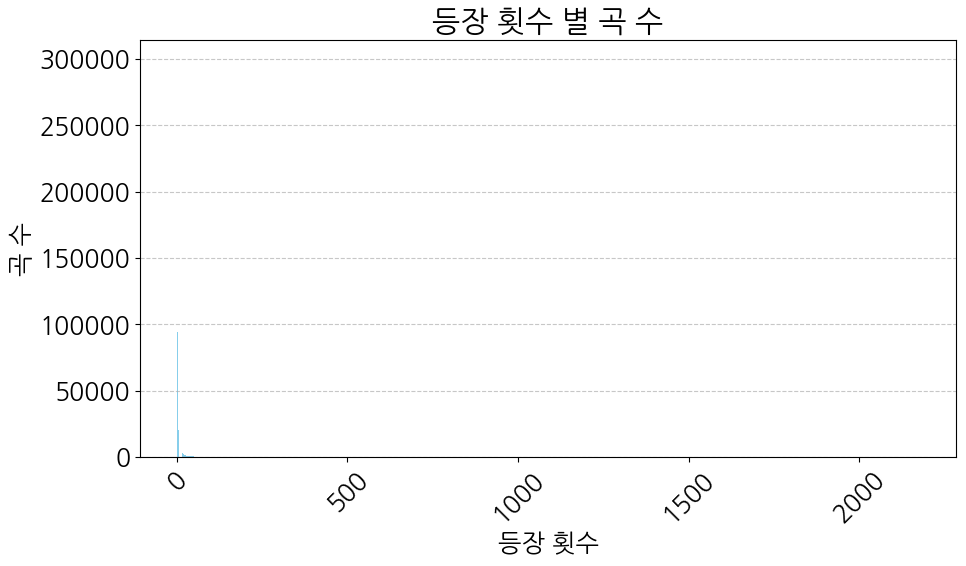

In [270]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(grouped['등장횟수'], grouped['곡 수'], color='skyblue')
plt.xlabel('등장 횟수')
plt.ylabel('곡 수')
plt.title('등장 횟수 별 곡 수')
plt.xticks(rotation=45)  # x축 레이블 회전
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [271]:
song_counts_df.describe()

,song,등장횟수
count,615142.000000,615142.000000
mean,353955.493888,8.592928
std,204338.932425,39.481912
min,0.000000,1.000000
25%,176957.250000,1.000000
50%,353982.500000,2.000000
75%,530864.750000,4.000000
max,707988.000000,2175.000000


- 각 태그별 플레이리스트에 사용된 횟수

    - 대부분의 태그들이 10번 이하로 사용됨

In [272]:
all_tag = [tag for sublist in train['tags'] for tag in sublist]

all_tag
tag_counts = Counter(all_tag)
tag_counts_df = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['등장횟수'])

# 인덱스의 이름 설정
tag_counts_df.index.name = 'tag'
tag_counts_df.reset_index(inplace=True)
tag_counts_df = tag_counts_df.sort_values('등장횟수', ascending=False)
tag_counts_df = tag_counts_df.groupby('등장횟수').count()['tag'].reset_index(name='tag_cnt')

tag_counts_df

,등장횟수,tag_cnt
0,1,17431
1,2,3944
2,3,1803
3,4,1053
4,5,704
...,...,...
388,10218,1
389,10796,1
390,11215,1
391,11417,1


In [273]:
tag_counts_df.info()
# sum(tag_counts_df['tag_cnt']) -> 29160

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   등장횟수     393 non-null    int64
 1   tag_cnt  393 non-null    int64
dtypes: int64(2)
memory usage: 6.3 KB


In [274]:
tag_counts_df['비율'] = tag_counts_df['tag_cnt'].apply(lambda x: x/sum(tag_counts_df['tag_cnt'])*100)
tag_counts_df['비율'] = tag_counts_df['비율'].round(4)
tag_counts_df['누적비율'] = tag_counts_df['비율'].cumsum()
tag_counts_df

,등장횟수,tag_cnt,비율,누적비율
0,1,17431,59.7771,59.7771
1,2,3944,13.5254,73.3025
2,3,1803,6.1831,79.4856
3,4,1053,3.6111,83.0967
4,5,704,2.4143,85.5110
...,...,...,...,...
388,10218,1,0.0034,99.9828
389,10796,1,0.0034,99.9862
390,11215,1,0.0034,99.9896
391,11417,1,0.0034,99.9930


In [275]:
tag_counts_df.iloc[:10, :]

,등장횟수,tag_cnt,비율,누적비율
0,1,17431,59.7771,59.7771
1,2,3944,13.5254,73.3025
2,3,1803,6.1831,79.4856
3,4,1053,3.6111,83.0967
4,5,704,2.4143,85.5110
5,6,527,1.8073,87.3183
6,7,390,1.3374,88.6557
7,8,285,0.9774,89.6331
8,9,243,0.8333,90.4664
9,10,200,0.6859,91.1523


- 곡 별 매핑되는 태그 수 집계

In [276]:
# 곡 별 매핑되는 태그 수 집계 : song_tag_map_cnt
song_tag_map_cnt = plylst_song_tag_map.groupby('songs').tags.nunique().reset_index(name = 'tags_cnt')

round(song_tag_map_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
tags_cnt,1.0,2.0,7.0,17.86,15.0,1928.0,44.95


- 특정 곡의 가장 빈도수 높은 태그 기준 유사 음악 찾기  
    - 헤이즈 ‘비도 오고 그래서＇

- ‘감성’ 태그가 가장 많이 활용되었으며, ＇감성’태그 기준 상위 곡 하기 표와 같음
- 빈도수 태그 기준으로 유사 음악을 찾을 경우, 태그마다 같은 결과가 나오는 한계점 有  
    ex)   아이유-밤편지 역시 ‘감성’이 가장 많이 쓰여 같은 결과 나옴


In [277]:
# 학습 데이터 내에서 가장 많은 태그가 매핑된 아이유 - 밤편지 (144663) 예시

# 13위 174749 헤이즈-비도 오고 그래서
example_song = plylst_song_tag_map[plylst_song_tag_map['songs'] == '174749']
example_song

,id,songs,tags,gnr_code_name
20658,28452,174749,런쥔,GN0400 (R&B/Soul)
20659,28452,174749,라디오,GN0400 (R&B/Soul)
32704,73145,174749,기분전환,GN0400 (R&B/Soul)
32705,73145,174749,휴식,GN0400 (R&B/Soul)
32706,73145,174749,느낌있는,GN0400 (R&B/Soul)
...,...,...,...,...
29582319,44994,174749,피쳐링,GN0400 (R&B/Soul)
29582320,44994,174749,그루브,GN0400 (R&B/Soul)
29603435,15976,174749,가을비,GN0400 (R&B/Soul)
29603436,15976,174749,가을,GN0400 (R&B/Soul)


In [278]:
example_temp = plylst_song_tag_map.loc[plylst_song_tag_map['tags'] == '감성', :].groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt').sort_values(by = 'mapping_plylst_cnt', ascending = False)
pd.merge(example_temp, song_meta[['id', 'song_name', 'artist_name_basket']], how = 'left', left_on = 'songs', right_on = 'id').head(10)

,songs,mapping_plylst_cnt,id,song_name,artist_name_basket
0,357367,735,357367,비,[폴킴]
1,144663,690,144663,밤편지,[아이유]
2,519391,678,519391,Love Again,[김제훈]
3,640657,667,640657,내가 말하고 싶은건,[김제훈]
4,463173,662,463173,비가 내렸어 (Vocal by 스티브언니),[업라이트 (Upright)]
5,349492,659,349492,어떤이별,[임승부]
6,427724,653,427724,지워줄게 (Vocal by 스티브언니),[아재]
7,680366,650,680366,끝내지 못한 이야기 (Feat. 호수),[어쿠스틱 멜로디 (Acoustic Melody)]
8,520093,641,520093,고마운 사람 (Vocal by 이소진),[업라이트 (Upright)]
9,215411,639,215411,지금보다 조금 (Feat. 이원),[어쿠스틱 멜로디 (Acoustic Melody)]


- 태그 별 사용된 플레이리스트 개수

In [279]:
# 태그 별 플레이리스트 unset
tags_plylst_title = train[['tags', 'plylst_title']]

tags_plylst_title_unnest = np.dstack(
    (
        np.repeat(tags_plylst_title.plylst_title.values, list(map(len, tags_plylst_title.tags))), 
        np.concatenate(tags_plylst_title.tags.values)
    )
)

tags_plylst_title_map = pd.DataFrame(tags_plylst_title_unnest[0])
tags_plylst_title_map.columns
tags_plylst_title_map.columns = ['plylst_title', 'tags']
tags_plylst_title_map.head()

,plylst_title,tags
0,여행같은 음악,락
1,요즘 너 말야,추억
2,요즘 너 말야,회상
3,"편하게, 잔잔하게 들을 수 있는 곡.-",까페
4,"편하게, 잔잔하게 들을 수 있는 곡.-",잔잔한


In [280]:
tags_plylst_title_map = tags_plylst_title_map.groupby('tags').plylst_title.apply(list).reset_index()
tags_plylst_title_map['plylst_title_num'] = tags_plylst_title_map['plylst_title'].apply(lambda x : len(x))
tags_plylst_title_map = tags_plylst_title_map.sort_values('plylst_title_num', ascending=False)
tags_plylst_title_map

,tags,plylst_title,plylst_title_num
7065,기분전환,"[2017 Pop Trend, 노래로 의지를 불태우자! ""1일1다짐"" st용 프로필...",16465
5234,감성,"[나만 알고싶은 노래들, 지친 하루 끝, 힐링이 필요한 당신에게 추천하는 인디곡, ...",11417
28675,휴식,"[여행가는 길 이런음악과 함께 고고씽!!!, 8~90년대 우리나라 라디오에서 흘러나...",11215
12894,발라드,"[발라드로 감성을 발라드림(슬픔주의), 이별 후 당신의 마음을 울리는 노래, ♥이별...",10796
22262,잔잔한,"[편하게, 잔잔하게 들을 수 있는 곡.-, 멍청이.. 내맘도 몰라., ᴡʜɪᴛᴇ :...",10218
...,...,...,...
11807,멜랑꼴리랑,"[r e l a x m u s i c, 나홀로 주말]",1
11805,멜랑,[가을밤 멜랑한 재즈힙합],1
11803,멜데스,"[멜로디컬한 기타 리프, 깔끔한 훅 날리는 멜로딕 데스메탈]",1
11802,멘톨,[목캔디의 멘톨처럼 먹먹한 가슴을 뻥 뚫어줄 음악들],1


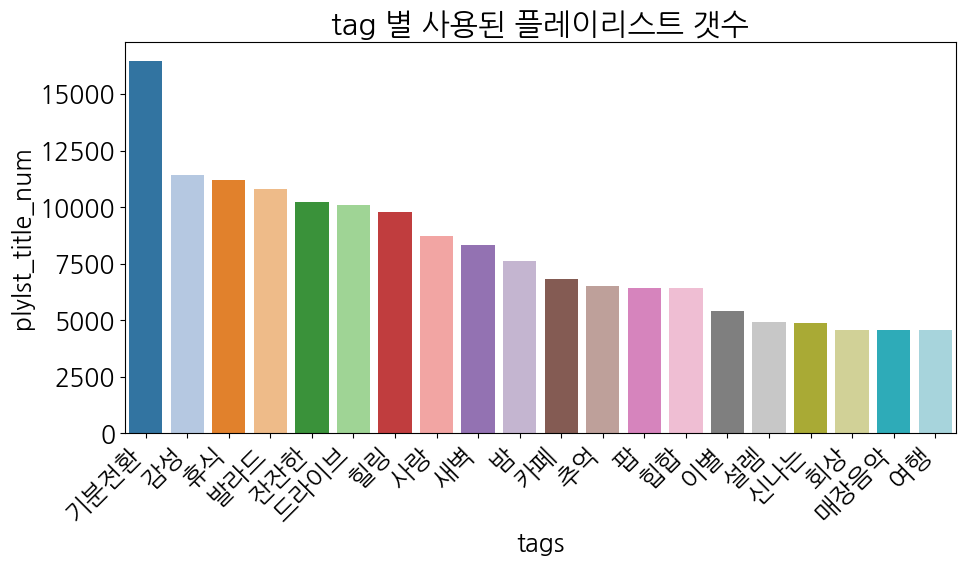

In [281]:
tmp = tags_plylst_title_map[:20]
color_palette = sns.color_palette('tab20', n_colors=20)

plt.figure(figsize=(10, 6))
sns.barplot(x='tags', y='plylst_title_num', data=tmp, palette=color_palette)
plt.xlabel('tags')
plt.ylabel('plylst_title_num')
plt.title('tag 별 사용된 플레이리스트 갯수')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()